In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import cupy as cp
from sklearn.decomposition import PCA
from xgboost import plot_importance
import wandb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [6]:
#Sadece deamnd verisi kullanma
# demand_array=df["total_demand"]
# n_steps=168
# n_forecast=24
# X, y = [], []
# for i in range(len(demand_array)):
#     # find the end of this pattern
#     end_ix = i + n_steps
#     # check if we are beyond the sequence
#     if end_ix > len(demand_array) - n_forecast:
#         break
#     # gather input and output parts of the pattern
#     seq_x = demand_array[i:end_ix].values
#     seq_y = demand_array[end_ix:n_forecast+end_ix].values
#     X.append(seq_x)
#     y.append(seq_y)
# X=np.array(X)
# y=np.array(y)


# # Calculate the index to split the data
# split_index = int(len(X) * 2 / 3)

# # Split the data into training and validation sets
# X_train = X[:split_index]
# y_train = y[:split_index]
# X_test = X[split_index:]
# y_test = y[split_index:]

In [4]:
df=pd.read_csv("df_xgboost.csv",delimiter=";")

In [5]:
df.columns

Index(['AIR_TEMP_MIN', 'PRCP', 'total_demand', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'week_of_year',
       'is_special_day', 'season_autumn', 'season_spring', 'season_winter',
       'hour_of_day'],
      dtype='object')

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
def generate_lagged_features(df, n_step,n_next):
    """
    Generate lagged features for the demand based on the n_step value and store the next 24 demand values as an array.

    Args:
    - df (pd.DataFrame): Original dataframe
    - n_step (int): Number of hours to consider for previous demand

    Returns:
    - df_new (pd.DataFrame): Dataframe with new features
    """

    # Creating lag features for demand
    for i in range(1, n_step + 1):
        df[f'demand_lag_{i}'] = df['total_demand'].shift(i)
    


    # Dropping rows with NaN values
    df_new = df.dropna()


    # Resetting index
    df_new = df_new.reset_index(drop=True)
    # Store the next 24 demand values as an array for the rows that will remain in the DataFrame
    next_demand_values = []
    # Calculate the next 24 demand values for each row
    for i in range(len(df_new) - n_next):
        next_demand_values.append(df_new['total_demand'].tolist()[i+1:i+n_next+1])
    print(np.array(next_demand_values).shape)
    df_new = df_new.iloc[:-n_next]
    # Add the next_24_demand values as a new column
    df_new['total_demand_'] = next_demand_values

    # Reshape the data for regression modeling
    df_test_ = pd.DataFrame(df_new['total_demand_'].tolist(), columns=[f'demand_{i+1}_hour' for i in range(n_next)])
    df_new = df_new.drop('total_demand_', axis=1)

    # Resetting index
    df_new = df_new.reset_index(drop=True)

    
    return df_new,df_test_

def minmax_scale_dataframe(data):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    return df_scaled


In [7]:
df_X,df_y = generate_lagged_features(df, n_step = 168,n_next=8)


C:\Users\murca\AppData\Local\Temp\ipykernel_1748\2553173045.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'demand_lag_{i}'] = df['total_demand'].shift(i)
C:\Users\murca\AppData\Local\Temp\ipykernel_1748\2553173045.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'demand_lag_{i}'] = df['total_demand'].shift(i)
C:\Users\murca\AppData\Local\Temp\ipykernel_1748\2553173045.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

(26128, 8)


In [11]:
#Special Day ekleme


# # Ensure valid_start column is of type datetime
# df_new['valid_start'] = pd.to_datetime(df_new['valid_start'])

# # Extract the day of the week
# df_new['day_of_week'] = df_new['valid_start'].dt.day_name()

# # One-hot encode the day_of_week column with only 6 dummy columns
# df_encoded = pd.get_dummies(df_new, columns=['day_of_week'], drop_first=True)
# df_encoded['week_of_year'] = df_encoded['valid_start'].dt.isocalendar().week
# # Define the special holidays
# special_holidays = [
#     "1-1",  # New Year's Day
#     "2-1",  # New Year's Day (additional day)
#     "26-1",  # Australia Day
#     "13-3",  # Labour Day
#     "7-4",  # Good Friday
#     "8-4",  # Easter Saturday
#     # Since you did not provide a date for "Easter Sunday", I'm omitting it.
#     "10-4",  # Easter Monday
#     "25-4",  # Anzac Day
#     "12-6",  # King's Birthday
#     # Omitting the AFL Grand Final date since it's TBC.
#     "7-11",  # Melbourne Cup
#     "25-12",  # Christmas Day
#     "26-12"  # Boxing Day
# ]
# def format_date(date):
#     formatted = date.strftime("%d-%m")
#     day, month = formatted.split('-')
#     return f"{int(day)}-{int(month)}"

# df_encoded['is_special_day'] = df_encoded['valid_start'].apply(lambda x: 1 if format_date(x) in special_holidays else 0)
# def get_season(date):
#     month = date.month
#     if 12 <= month <= 2:
#         return 'summer'
#     elif 3 <= month <= 5:
#         return 'autumn'
#     elif 6 <= month <= 8:
#         return 'winter'
#     elif 9 <= month <= 11:
#         return 'spring'
# # Add a 'season' column to the dataframe
# df_encoded['season'] = df_encoded['valid_start'].apply(get_season)

# # One-hot encode the 'season' column
# df_encoded = pd.get_dummies(df_encoded, columns=['season'], prefix='season')
# # Extract hour from the 'valid_start' column
# df_encoded['hour_of_day'] = df_encoded['valid_start'].dt.hour

# # Create a 'season_label' column to convert one-hot encoding to a single column of season labels
# conditions = [
#     df_encoded['season_autumn'] == 1,
#     df_encoded['season_spring'] == 1,
#     df_encoded['season_winter'] == 1
# ]

# choices = ['Autumn', 'Spring', 'Winter']

# df_encoded['season_label'] = np.select(conditions, choices, default='Summer')

# df_encoded['year'] = df_encoded['valid_start'].dt.year
# days_columns = ['day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 'day_of_week_Sunday']

# df_encoded['day_name'] = df_encoded[days_columns].idxmax(axis=1).str.split('_').str[-1]
# # Extract just the date from the valid_start column
# df_encoded['date'] = df_encoded['valid_start'].dt.date

# def get_label_from_one_hot(row, prefix, categories):
#     """ This function will return the label by checking which column is set to 1 for one-hot encoded columns. 
#         If all are 0, return the dropped category, assumed to be the first in the provided categories list. """
#     for col in row.index:
#         if col.startswith(prefix) and row[col] == 1:
#             return col.split('_')[-1]
#     return categories[0]  # Assuming the first category is the one dropped

# # List of original categories before creating dummy variables
# original_day_categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# original_season_categories = ['spring', 'summer', 'autumn', 'winter']

# # Apply the function to each row for day_of_week and season
# df_new['day_of_week_label'] = df_new.apply(lambda row: get_label_from_one_hot(row, 'day_of_week', original_day_categories), axis=1)
# df_new['season_label'] = df_new.apply(lambda row: get_label_from_one_hot(row, 'season', original_season_categories), axis=1)

In [8]:
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
split_val_index = int(len(df_X) * 2 / 3)
split_test_index = int(len(df_X) * 5 / 6)
# Separate independent and dependent variables for training set
X_train = df_X.loc[:split_val_index].values
y_train = df_y.loc[:split_val_index].values

# Separate independent and dependent variables for validation set
X_val = df_X.loc[split_val_index:split_test_index].values
y_val = df_y.loc[split_val_index:split_test_index].values

X_test = df_X.loc[split_test_index:].values
y_test = df_y.loc[split_test_index:].values


scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train=scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
X_val = scaler_X.transform(X_val)

In [13]:

# pca = PCA(n_components=0.99)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [9]:
X_train.shape

(17419, 183)

In [92]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

0

In [10]:
wandb.init(project="DI502_PROJECT")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: muratcankaplann98. Use `wandb login --relogin` to force relogin


In [13]:
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
        'name': 'loss',
        'goal': 'minimize'   
    },
    'parameters': {
        'booster': {
            'value': 'gbtree'
        },
        'objective': {
            'value': 'reg:squarederror'
        },
        'colsample_bytree': {
            'min': 0.1,
            'max': 1.0
        },
        'learning_rate': {
            'min': 0.01,
            'max': 0.5
        },
        'max_depth': {
            'min': 3,
            'max': 10
        },
        'sampling_method': {
            'value': 'gradient_based'
        },
        'alpha': {
            'min': 0,
            'max': 100
        },
        'n_estimators': {
            'values': [100, 200, 300, 400, 500]
        },
        'grow_policy': {
            'value': 'lossguide'
        },
    }
    # No need to include 'stop' for Bayesian optimization
    # But you can still include it if you want to limit the number of runs
}



In [14]:
def train():
    with wandb.init() as run:
        config = run.config

        # Initialize the XGBoost model with the specified parameters from the sweep
        model = xgb.XGBRegressor(
            booster=config.booster,
            objective=config.objective,
            colsample_bytree=config.colsample_bytree,
            learning_rate=config.learning_rate,
            max_depth=int(config.max_depth),
            sampling_method=config.sampling_method,
            alpha=config.alpha,
            n_estimators=config.n_estimators,
            grow_policy=config.grow_policy,
            tree_method='gpu_hist',  # Ensures computation is done on GPU
            predictor='gpu_predictor'  # Ensures prediction is done on GPU
        )
        
        # Fit the model (no need to convert to Cupy, XGBoost handles GPU operations)
        eval_set = [(X_train, y_train), (X_val, y_val)]
        model.fit(X_train, y_train, eval_set=eval_set, verbose=True)
        
        # Evaluate the model
        mse_train, mape_train = evaluate_model(model, X_train, y_train)
        mse_val, mape_val = evaluate_model(model, X_val, y_val)
        mse_test, mape_test = evaluate_model(model, X_test, y_test)
        
        # Log the metrics to wandb
        wandb.log({
            "mse_train": mse_train, "mape_train": mape_train,
            "mse_val": mse_val, "mape_val": mape_val,
            "mse_test": mse_test, "mape_test": mape_test,
            "loss": mape_test  # This is the metric we want to minimize
        })


In [15]:
def evaluate_model(model, X, y):
    # Make predictions on the provided dataset
    predictions = model.predict(X)

    # Calculate MSE and MAPE
    mse = mean_squared_error(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)

    return mse, mape

In [16]:
sweep_id = wandb.sweep(sweep_config, project='DI502_PROJECT')
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: hg5769yf
Sweep URL: https://wandb.ai/muratcankaplann98/DI502_PROJECT/sweeps/hg5769yf


wandb: Agent Starting Run: 8m7m6s5z with config:
wandb: 	alpha: 70
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.66627973266956
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.031448702074092796
wandb: 	max_depth: 6
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1727.33006	validation_1-rmse:1605.73727
[1]	validation_0-rmse:1683.15846	validation_1-rmse:1564.00869
[2]	validation_0-rmse:1640.58223	validation_1-rmse:1523.88442
[3]	validation_0-rmse:1599.41830	validation_1-rmse:1485.23228
[4]	validation_0-rmse:1559.37330	validation_1-rmse:1447.26820
[5]	validation_0-rmse:1520.42111	validation_1-rmse:1410.73496
[6]	validation_0-rmse:1482.81030	validation_1-rmse:1375.53755
[7]	validation_0-rmse:1446.71093	validation_1-rmse:1341.19390
[8]	validation_0-rmse:1411.23336	validation_1-rmse:1308.05044
[9]	validation_0-rmse:1377.08236	validation_1-rmse:1275.87240
[10]	validation_0-rmse:1344.54045	validation_1-rmse:1245.53050
[11]	validation_0-rmse:1313.16844	validation_1-rmse:1216.06380
[12]	validation_0-rmse:1282.77571	validation_1-rmse:1187.78163
[13]	validation_0-rmse:1252.64999	validation_1-rmse:1159.60051
[14]	validation_0-rmse:1224.37124	validation_1-rmse:1133.08837
[15]	validation_0-rmse:1197.05768	validation_1-rmse:1107.37364
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03736
mape_test,0.03736
mape_train,0.02267
mape_val,0.02845


wandb: Agent Starting Run: ryz77ulm with config:
wandb: 	alpha: 68
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.23027974853486177
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.11999864842704765
wandb: 	max_depth: 5
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1618.54923	validation_1-rmse:1497.36756
[1]	validation_0-rmse:1490.30734	validation_1-rmse:1369.28386
[2]	validation_0-rmse:1369.34039	validation_1-rmse:1250.35545
[3]	validation_0-rmse:1271.10664	validation_1-rmse:1154.33553
[4]	validation_0-rmse:1182.08181	validation_1-rmse:1069.39893
[5]	validation_0-rmse:1099.74692	validation_1-rmse:992.49588
[6]	validation_0-rmse:1025.53510	validation_1-rmse:923.50101
[7]	validation_0-rmse:965.49650	validation_1-rmse:867.41390
[8]	validation_0-rmse:911.06629	validation_1-rmse:816.74921
[9]	validation_0-rmse:868.12194	validation_1-rmse:777.02093
[10]	validation_0-rmse:825.16522	validation_1-rmse:739.66767
[11]	validation_0-rmse:788.01644	validation_1-rmse:708.79349
[12]	validation_0-rmse:760.17508	validation_1-rmse:682.32729
[13]	validation_0-rmse:731.22861	validation_1-rmse:658.68878
[14]	validation_0-rmse:705.38329	validation_1-rmse:638.96665
[15]	validation_0-rmse:685.99158	validation_1-rmse:622.68007
[16]	validation_0-rmse

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03798
mape_test,0.03798
mape_train,0.01966
mape_val,0.02914


wandb: Agent Starting Run: bj0i91r2 with config:
wandb: 	alpha: 11
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.178968709652762
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.12311449965812436
wandb: 	max_depth: 4
wandb: 	n_estimators: 100
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1628.59328	validation_1-rmse:1505.94945
[1]	validation_0-rmse:1509.85596	validation_1-rmse:1384.59854
[2]	validation_0-rmse:1398.53883	validation_1-rmse:1273.51926
[3]	validation_0-rmse:1307.97656	validation_1-rmse:1182.14494
[4]	validation_0-rmse:1222.99960	validation_1-rmse:1098.63032
[5]	validation_0-rmse:1149.45126	validation_1-rmse:1025.04221
[6]	validation_0-rmse:1079.34326	validation_1-rmse:959.41698
[7]	validation_0-rmse:1024.29605	validation_1-rmse:904.84039
[8]	validation_0-rmse:974.75880	validation_1-rmse:856.52372
[9]	validation_0-rmse:936.35761	validation_1-rmse:818.87833
[10]	validation_0-rmse:897.22273	validation_1-rmse:782.70863
[11]	validation_0-rmse:862.02852	validation_1-rmse:752.58147
[12]	validation_0-rmse:836.01505	validation_1-rmse:726.30981
[13]	validation_0-rmse:811.91508	validation_1-rmse:704.63393
[14]	validation_0-rmse:791.04406	validation_1-rmse:683.98763
[15]	validation_0-rmse:772.57558	validation_1-rmse:667.06596
[16]	validation_0-rm

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04316
mape_test,0.04316
mape_train,0.03095
mape_val,0.03253


wandb: Agent Starting Run: 5ach53uj with config:
wandb: 	alpha: 56
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7909354385596966
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.04792938434505093
wandb: 	max_depth: 7
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1700.89066	validation_1-rmse:1581.58449
[1]	validation_0-rmse:1631.96352	validation_1-rmse:1517.85049
[2]	validation_0-rmse:1566.35201	validation_1-rmse:1457.06153
[3]	validation_0-rmse:1504.18104	validation_1-rmse:1399.45181
[4]	validation_0-rmse:1444.54206	validation_1-rmse:1344.55941
[5]	validation_0-rmse:1387.79779	validation_1-rmse:1292.45487
[6]	validation_0-rmse:1334.22316	validation_1-rmse:1242.69862
[7]	validation_0-rmse:1283.28959	validation_1-rmse:1196.11358
[8]	validation_0-rmse:1234.82634	validation_1-rmse:1152.47264
[9]	validation_0-rmse:1188.99367	validation_1-rmse:1110.05242
[10]	validation_0-rmse:1145.54965	validation_1-rmse:1071.28102
[11]	validation_0-rmse:1103.77206	validation_1-rmse:1033.35417
[12]	validation_0-rmse:1064.66307	validation_1-rmse:997.94323
[13]	validation_0-rmse:1027.03541	validation_1-rmse:964.17640
[14]	validation_0-rmse:991.66941	validation_1-rmse:932.88946
[15]	validation_0-rmse:958.29905	validation_1-rmse:903.38228
[16]	val

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03605
mape_test,0.03605
mape_train,0.01532
mape_val,0.02721


wandb: Agent Starting Run: crs5bauo with config:
wandb: 	alpha: 53
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.990583757799155
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.11870359522352236
wandb: 	max_depth: 8
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1588.80861	validation_1-rmse:1479.38079
[1]	validation_0-rmse:1426.77109	validation_1-rmse:1331.62215
[2]	validation_0-rmse:1284.11786	validation_1-rmse:1202.27770
[3]	validation_0-rmse:1158.68545	validation_1-rmse:1090.25938
[4]	validation_0-rmse:1048.50437	validation_1-rmse:993.10841
[5]	validation_0-rmse:951.75647	validation_1-rmse:909.22702
[6]	validation_0-rmse:866.63679	validation_1-rmse:836.05619
[7]	validation_0-rmse:792.34902	validation_1-rmse:773.92176
[8]	validation_0-rmse:727.18877	validation_1-rmse:720.58752
[9]	validation_0-rmse:670.06674	validation_1-rmse:674.26742
[10]	validation_0-rmse:620.19426	validation_1-rmse:635.86828
[11]	validation_0-rmse:576.96089	validation_1-rmse:602.77996
[12]	validation_0-rmse:539.06389	validation_1-rmse:575.14866
[13]	validation_0-rmse:505.70627	validation_1-rmse:551.57197
[14]	validation_0-rmse:476.08333	validation_1-rmse:531.95444
[15]	validation_0-rmse:449.76396	validation_1-rmse:514.57604
[16]	validation_0-rmse:42

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.0371
mape_test,0.0371
mape_train,0.00522
mape_val,0.02754


wandb: Agent Starting Run: 4cjki25d with config:
wandb: 	alpha: 68
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6346239102908066
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.09237617453908732
wandb: 	max_depth: 10
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1626.74984	validation_1-rmse:1516.71035
[1]	validation_0-rmse:1493.33087	validation_1-rmse:1396.73594
[2]	validation_0-rmse:1372.14843	validation_1-rmse:1288.48767
[3]	validation_0-rmse:1262.10700	validation_1-rmse:1191.42844
[4]	validation_0-rmse:1161.42746	validation_1-rmse:1103.99735
[5]	validation_0-rmse:1069.76318	validation_1-rmse:1025.92187
[6]	validation_0-rmse:986.17778	validation_1-rmse:955.37191
[7]	validation_0-rmse:911.08622	validation_1-rmse:893.04337
[8]	validation_0-rmse:841.68155	validation_1-rmse:836.38310
[9]	validation_0-rmse:779.24227	validation_1-rmse:786.30212
[10]	validation_0-rmse:721.80959	validation_1-rmse:741.51820
[11]	validation_0-rmse:670.28062	validation_1-rmse:701.85986
[12]	validation_0-rmse:623.28489	validation_1-rmse:667.28063
[13]	validation_0-rmse:580.18197	validation_1-rmse:636.34430
[14]	validation_0-rmse:541.37630	validation_1-rmse:609.56368
[15]	validation_0-rmse:506.41061	validation_1-rmse:586.18114
[16]	validation_0-rmse

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03987
mape_test,0.03987
mape_train,0.00078
mape_val,0.02794


wandb: Agent Starting Run: q00eecxi with config:
wandb: 	alpha: 39
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7788600932173987
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.012849353435770271
wandb: 	max_depth: 6
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1754.37505	validation_1-rmse:1631.12603
[1]	validation_0-rmse:1735.75435	validation_1-rmse:1613.66668
[2]	validation_0-rmse:1717.33450	validation_1-rmse:1596.38911
[3]	validation_0-rmse:1699.24060	validation_1-rmse:1579.37099
[4]	validation_0-rmse:1681.33675	validation_1-rmse:1562.55564
[5]	validation_0-rmse:1663.57873	validation_1-rmse:1545.91146
[6]	validation_0-rmse:1646.16230	validation_1-rmse:1529.46194
[7]	validation_0-rmse:1628.95006	validation_1-rmse:1513.14689
[8]	validation_0-rmse:1611.92702	validation_1-rmse:1497.32561
[9]	validation_0-rmse:1595.20213	validation_1-rmse:1481.43525
[10]	validation_0-rmse:1578.83832	validation_1-rmse:1466.13024
[11]	validation_0-rmse:1562.55408	validation_1-rmse:1450.77798
[12]	validation_0-rmse:1546.56713	validation_1-rmse:1435.80689
[13]	validation_0-rmse:1530.59888	validation_1-rmse:1420.93530
[14]	validation_0-rmse:1515.14195	validation_1-rmse:1406.40451
[15]	validation_0-rmse:1499.95337	validation_1-rmse:1392.07803
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04703
mape_test,0.04703
mape_train,0.0347
mape_val,0.03564


wandb: Agent Starting Run: b6eqbvuu with config:
wandb: 	alpha: 29
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7049047402015363
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.4077857117426319
wandb: 	max_depth: 3
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1300.73247	validation_1-rmse:1178.88221
[1]	validation_0-rmse:1050.37206	validation_1-rmse:916.53029
[2]	validation_0-rmse:909.28997	validation_1-rmse:778.77894
[3]	validation_0-rmse:823.03774	validation_1-rmse:698.17252
[4]	validation_0-rmse:770.63900	validation_1-rmse:653.56723
[5]	validation_0-rmse:727.62145	validation_1-rmse:626.88804
[6]	validation_0-rmse:700.55457	validation_1-rmse:610.70843
[7]	validation_0-rmse:676.56127	validation_1-rmse:593.14380
[8]	validation_0-rmse:653.07890	validation_1-rmse:582.12128
[9]	validation_0-rmse:637.53009	validation_1-rmse:572.89151
[10]	validation_0-rmse:621.88361	validation_1-rmse:563.23899
[11]	validation_0-rmse:610.89295	validation_1-rmse:554.37567
[12]	validation_0-rmse:600.04753	validation_1-rmse:547.52096
[13]	validation_0-rmse:589.30590	validation_1-rmse:539.33497
[14]	validation_0-rmse:581.32813	validation_1-rmse:535.20837
[15]	validation_0-rmse:572.70880	validation_1-rmse:529.39031
[16]	validation_0-rmse:565.7554

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03885
mape_test,0.03885
mape_train,0.02283
mape_val,0.03049


wandb: Agent Starting Run: 6qmfejha with config:
wandb: 	alpha: 32
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.5298180857083042
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.335354628666802
wandb: 	max_depth: 3
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1392.51693	validation_1-rmse:1261.60024
[1]	validation_0-rmse:1154.91448	validation_1-rmse:1019.17101
[2]	validation_0-rmse:997.15983	validation_1-rmse:861.99575
[3]	validation_0-rmse:905.98331	validation_1-rmse:769.69138
[4]	validation_0-rmse:829.51762	validation_1-rmse:706.99253
[5]	validation_0-rmse:778.21804	validation_1-rmse:672.17898
[6]	validation_0-rmse:739.03399	validation_1-rmse:645.16743
[7]	validation_0-rmse:713.95054	validation_1-rmse:625.17973
[8]	validation_0-rmse:687.34320	validation_1-rmse:608.21068
[9]	validation_0-rmse:669.92858	validation_1-rmse:594.19346
[10]	validation_0-rmse:654.38106	validation_1-rmse:584.48882
[11]	validation_0-rmse:641.05938	validation_1-rmse:576.07115
[12]	validation_0-rmse:628.57936	validation_1-rmse:566.26574
[13]	validation_0-rmse:617.06973	validation_1-rmse:558.20342
[14]	validation_0-rmse:606.90199	validation_1-rmse:553.20962
[15]	validation_0-rmse:598.59471	validation_1-rmse:548.76044
[16]	validation_0-rmse:590.528

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03822
mape_test,0.03822
mape_train,0.02395
mape_val,0.03046


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xymkczb2 with config:
wandb: 	alpha: 25
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.4514204070710315
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.27073369307652884
wandb: 	max_depth: 7
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1387.66082	validation_1-rmse:1286.02723
[1]	validation_0-rmse:1109.03492	validation_1-rmse:1029.89200
[2]	validation_0-rmse:905.11857	validation_1-rmse:848.93221
[3]	validation_0-rmse:767.04716	validation_1-rmse:729.90148
[4]	validation_0-rmse:658.14783	validation_1-rmse:642.12026
[5]	validation_0-rmse:580.02048	validation_1-rmse:586.58922
[6]	validation_0-rmse:524.15492	validation_1-rmse:550.87724
[7]	validation_0-rmse:486.92084	validation_1-rmse:527.85072
[8]	validation_0-rmse:452.89116	validation_1-rmse:507.51751
[9]	validation_0-rmse:429.43084	validation_1-rmse:494.17912
[10]	validation_0-rmse:409.62139	validation_1-rmse:484.24678
[11]	validation_0-rmse:391.83429	validation_1-rmse:474.26455
[12]	validation_0-rmse:377.96781	validation_1-rmse:468.38874
[13]	validation_0-rmse:364.13581	validation_1-rmse:462.38556
[14]	validation_0-rmse:352.64758	validation_1-rmse:458.12853
[15]	validation_0-rmse:343.27750	validation_1-rmse:454.20383
[16]	validation_0-rmse:335.778

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04147
mape_test,0.04147
mape_train,0.00048
mape_val,0.03042


wandb: Agent Starting Run: r7lixj4f with config:
wandb: 	alpha: 65
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.5329713777140005
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.15543100754490985
wandb: 	max_depth: 8
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1541.07879	validation_1-rmse:1436.06224
[1]	validation_0-rmse:1344.91139	validation_1-rmse:1255.61107
[2]	validation_0-rmse:1176.64085	validation_1-rmse:1104.62518
[3]	validation_0-rmse:1039.83677	validation_1-rmse:983.30422
[4]	validation_0-rmse:918.49802	validation_1-rmse:878.17450
[5]	validation_0-rmse:815.07754	validation_1-rmse:792.81743
[6]	validation_0-rmse:729.26322	validation_1-rmse:723.70326
[7]	validation_0-rmse:660.06227	validation_1-rmse:668.98348
[8]	validation_0-rmse:598.12263	validation_1-rmse:622.26068
[9]	validation_0-rmse:549.13769	validation_1-rmse:586.12407
[10]	validation_0-rmse:506.11733	validation_1-rmse:556.18266
[11]	validation_0-rmse:470.51487	validation_1-rmse:532.60909
[12]	validation_0-rmse:440.30885	validation_1-rmse:514.33228
[13]	validation_0-rmse:413.59060	validation_1-rmse:498.60070
[14]	validation_0-rmse:392.19826	validation_1-rmse:486.61928
[15]	validation_0-rmse:373.27229	validation_1-rmse:476.77396
[16]	validation_0-rmse:357.

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03938
mape_test,0.03938
mape_train,0.00094
mape_val,0.02845


wandb: Agent Starting Run: 8tsrcst2 with config:
wandb: 	alpha: 5
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9301021384700798
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.012486980405480555
wandb: 	max_depth: 8
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1753.71622	validation_1-rmse:1630.90591
[1]	validation_0-rmse:1734.46216	validation_1-rmse:1613.14694
[2]	validation_0-rmse:1715.45475	validation_1-rmse:1595.64345
[3]	validation_0-rmse:1696.72741	validation_1-rmse:1578.45539
[4]	validation_0-rmse:1678.14145	validation_1-rmse:1561.46800
[5]	validation_0-rmse:1659.82640	validation_1-rmse:1544.61422
[6]	validation_0-rmse:1641.72317	validation_1-rmse:1528.10231
[7]	validation_0-rmse:1623.91924	validation_1-rmse:1511.75130
[8]	validation_0-rmse:1606.30355	validation_1-rmse:1495.60850
[9]	validation_0-rmse:1588.93913	validation_1-rmse:1479.68343
[10]	validation_0-rmse:1571.81127	validation_1-rmse:1464.02493
[11]	validation_0-rmse:1554.85568	validation_1-rmse:1448.53386
[12]	validation_0-rmse:1538.14828	validation_1-rmse:1433.34485
[13]	validation_0-rmse:1521.56812	validation_1-rmse:1418.29772
[14]	validation_0-rmse:1505.33540	validation_1-rmse:1403.39790
[15]	validation_0-rmse:1489.24011	validation_1-rmse:1388.71675
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.0448
mape_test,0.0448
mape_train,0.02718
mape_val,0.03342


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: chjighjk with config:
wandb: 	alpha: 65
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.639786322996153
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.2991285242729537
wandb: 	max_depth: 4
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1394.09398	validation_1-rmse:1281.54999
[1]	validation_0-rmse:1139.51193	validation_1-rmse:1028.91349
[2]	validation_0-rmse:970.98769	validation_1-rmse:865.94524
[3]	validation_0-rmse:859.62825	validation_1-rmse:759.67537
[4]	validation_0-rmse:779.05693	validation_1-rmse:685.96065
[5]	validation_0-rmse:720.70773	validation_1-rmse:640.69697
[6]	validation_0-rmse:678.80843	validation_1-rmse:608.19168
[7]	validation_0-rmse:649.95036	validation_1-rmse:584.69647
[8]	validation_0-rmse:620.98895	validation_1-rmse:565.32523
[9]	validation_0-rmse:600.56301	validation_1-rmse:553.36605
[10]	validation_0-rmse:581.84910	validation_1-rmse:542.00034
[11]	validation_0-rmse:567.68721	validation_1-rmse:531.12508
[12]	validation_0-rmse:554.49276	validation_1-rmse:521.92700
[13]	validation_0-rmse:540.88640	validation_1-rmse:514.93584
[14]	validation_0-rmse:530.85400	validation_1-rmse:507.72342
[15]	validation_0-rmse:521.87281	validation_1-rmse:501.34057
[16]	validation_0-rmse:514.024

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03769
mape_test,0.03769
mape_train,0.01518
mape_val,0.02965


wandb: Agent Starting Run: yavauxpl with config:
wandb: 	alpha: 50
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.4332502458723396
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.4699495900912142
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1223.54042	validation_1-rmse:1103.89191
[1]	validation_0-rmse:952.97970	validation_1-rmse:840.72473
[2]	validation_0-rmse:810.67616	validation_1-rmse:715.82030
[3]	validation_0-rmse:745.43261	validation_1-rmse:660.47895
[4]	validation_0-rmse:688.62981	validation_1-rmse:619.29285
[5]	validation_0-rmse:650.77276	validation_1-rmse:599.52054
[6]	validation_0-rmse:624.21215	validation_1-rmse:584.30274
[7]	validation_0-rmse:604.36411	validation_1-rmse:567.94929
[8]	validation_0-rmse:584.17277	validation_1-rmse:558.55287
[9]	validation_0-rmse:570.60705	validation_1-rmse:550.43496
[10]	validation_0-rmse:557.98847	validation_1-rmse:542.59286
[11]	validation_0-rmse:547.04107	validation_1-rmse:536.96928
[12]	validation_0-rmse:536.73005	validation_1-rmse:532.18631
[13]	validation_0-rmse:525.79336	validation_1-rmse:526.72790
[14]	validation_0-rmse:516.77809	validation_1-rmse:521.41940
[15]	validation_0-rmse:510.55512	validation_1-rmse:517.95129
[16]	validation_0-rmse:503.70488

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.0423
mape_test,0.0423
mape_train,0.009
mape_val,0.03274


wandb: Agent Starting Run: ta90xihc with config:
wandb: 	alpha: 64
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6676959347129372
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.19568129425239864
wandb: 	max_depth: 7
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1482.80539	validation_1-rmse:1380.22334
[1]	validation_0-rmse:1251.31828	validation_1-rmse:1166.20724
[2]	validation_0-rmse:1067.75073	validation_1-rmse:997.41722
[3]	validation_0-rmse:921.01317	validation_1-rmse:867.51351
[4]	validation_0-rmse:804.27980	validation_1-rmse:766.58494
[5]	validation_0-rmse:710.60894	validation_1-rmse:688.41815
[6]	validation_0-rmse:637.38264	validation_1-rmse:631.57872
[7]	validation_0-rmse:581.86122	validation_1-rmse:587.32928
[8]	validation_0-rmse:533.93179	validation_1-rmse:552.71710
[9]	validation_0-rmse:496.86685	validation_1-rmse:525.71818
[10]	validation_0-rmse:465.15573	validation_1-rmse:504.60260
[11]	validation_0-rmse:440.29307	validation_1-rmse:489.23038
[12]	validation_0-rmse:417.81968	validation_1-rmse:476.63983
[13]	validation_0-rmse:400.13877	validation_1-rmse:467.30009
[14]	validation_0-rmse:385.29112	validation_1-rmse:459.88678
[15]	validation_0-rmse:372.35544	validation_1-rmse:453.15804
[16]	validation_0-rmse:360.81

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03788
mape_test,0.03788
mape_train,0.00317
mape_val,0.02838


wandb: Agent Starting Run: 2cgu74dh with config:
wandb: 	alpha: 65
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.2917181983333784
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.4086494784774522
wandb: 	max_depth: 4
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1296.17410	validation_1-rmse:1169.60162
[1]	validation_0-rmse:1035.21579	validation_1-rmse:913.54865
[2]	validation_0-rmse:875.88050	validation_1-rmse:761.81473
[3]	validation_0-rmse:797.82307	validation_1-rmse:689.77361
[4]	validation_0-rmse:732.56189	validation_1-rmse:641.26617
[5]	validation_0-rmse:691.97002	validation_1-rmse:615.96333
[6]	validation_0-rmse:660.59736	validation_1-rmse:598.15768
[7]	validation_0-rmse:641.02086	validation_1-rmse:582.50581
[8]	validation_0-rmse:619.42056	validation_1-rmse:570.60205
[9]	validation_0-rmse:603.98254	validation_1-rmse:561.08455
[10]	validation_0-rmse:588.66748	validation_1-rmse:552.82516
[11]	validation_0-rmse:573.80074	validation_1-rmse:545.30599
[12]	validation_0-rmse:564.58984	validation_1-rmse:540.99044
[13]	validation_0-rmse:552.60990	validation_1-rmse:534.90022
[14]	validation_0-rmse:542.91929	validation_1-rmse:531.46430
[15]	validation_0-rmse:534.99270	validation_1-rmse:526.48725
[16]	validation_0-rmse:528.7822

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04162
mape_test,0.04162
mape_train,0.01846
mape_val,0.03207


wandb: Agent Starting Run: 09f3mqzx with config:
wandb: 	alpha: 48
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.899219714010007
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.39077518237844394
wandb: 	max_depth: 8
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1182.91511	validation_1-rmse:1110.25326
[1]	validation_0-rmse:832.53556	validation_1-rmse:807.44662
[2]	validation_0-rmse:624.58136	validation_1-rmse:641.28454
[3]	validation_0-rmse:502.12868	validation_1-rmse:556.66327
[4]	validation_0-rmse:427.33023	validation_1-rmse:511.97218
[5]	validation_0-rmse:378.37171	validation_1-rmse:487.00270
[6]	validation_0-rmse:344.92508	validation_1-rmse:473.98691
[7]	validation_0-rmse:321.04899	validation_1-rmse:465.48999
[8]	validation_0-rmse:302.43559	validation_1-rmse:460.13189
[9]	validation_0-rmse:287.41451	validation_1-rmse:455.52267
[10]	validation_0-rmse:273.38594	validation_1-rmse:452.53081
[11]	validation_0-rmse:263.57761	validation_1-rmse:450.69034
[12]	validation_0-rmse:255.00312	validation_1-rmse:449.37842
[13]	validation_0-rmse:247.50866	validation_1-rmse:448.47396
[14]	validation_0-rmse:240.72299	validation_1-rmse:447.61167
[15]	validation_0-rmse:234.08836	validation_1-rmse:446.58480
[16]	validation_0-rmse:228.71225

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04266
mape_test,0.04266
mape_train,0.00018
mape_val,0.03144


wandb: Agent Starting Run: snyyymwg with config:
wandb: 	alpha: 84
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.42498420688059046
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.4587948585916179
wandb: 	max_depth: 4
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1234.73938	validation_1-rmse:1115.04310
[1]	validation_0-rmse:963.18372	validation_1-rmse:851.31408
[2]	validation_0-rmse:817.22630	validation_1-rmse:722.08306
[3]	validation_0-rmse:750.12529	validation_1-rmse:663.37659
[4]	validation_0-rmse:694.28000	validation_1-rmse:621.73589
[5]	validation_0-rmse:656.55896	validation_1-rmse:600.05899
[6]	validation_0-rmse:629.47900	validation_1-rmse:586.48083
[7]	validation_0-rmse:608.79715	validation_1-rmse:569.75554
[8]	validation_0-rmse:588.91750	validation_1-rmse:560.42667
[9]	validation_0-rmse:574.84262	validation_1-rmse:552.46517
[10]	validation_0-rmse:560.65323	validation_1-rmse:542.81740
[11]	validation_0-rmse:548.48164	validation_1-rmse:535.16307
[12]	validation_0-rmse:538.34804	validation_1-rmse:528.91731
[13]	validation_0-rmse:528.77319	validation_1-rmse:523.97804
[14]	validation_0-rmse:519.45787	validation_1-rmse:518.65257
[15]	validation_0-rmse:512.74791	validation_1-rmse:515.77011
[16]	validation_0-rmse:505.61114

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04192
mape_test,0.04192
mape_train,0.01116
mape_val,0.03224


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ks1a0853 with config:
wandb: 	alpha: 93
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.753636971461697
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.4520946853975003
wandb: 	max_depth: 5
wandb: 	n_estimators: 100
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1176.92527	validation_1-rmse:1078.91935
[1]	validation_0-rmse:879.10493	validation_1-rmse:793.84730
[2]	validation_0-rmse:727.69584	validation_1-rmse:658.12579
[3]	validation_0-rmse:644.31204	validation_1-rmse:590.18087
[4]	validation_0-rmse:589.85276	validation_1-rmse:555.54892
[5]	validation_0-rmse:552.58371	validation_1-rmse:530.97207
[6]	validation_0-rmse:526.35287	validation_1-rmse:516.63771
[7]	validation_0-rmse:508.05808	validation_1-rmse:506.21191
[8]	validation_0-rmse:491.82048	validation_1-rmse:497.65835
[9]	validation_0-rmse:479.37672	validation_1-rmse:491.86949
[10]	validation_0-rmse:468.70819	validation_1-rmse:486.69080
[11]	validation_0-rmse:458.25895	validation_1-rmse:481.59246
[12]	validation_0-rmse:449.75065	validation_1-rmse:477.38863
[13]	validation_0-rmse:440.29423	validation_1-rmse:473.78030
[14]	validation_0-rmse:433.67497	validation_1-rmse:471.29303
[15]	validation_0-rmse:426.44551	validation_1-rmse:469.03811
[16]	validation_0-rmse:420.71006

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04229
mape_test,0.04229
mape_train,0.01683
mape_val,0.0324


wandb: Agent Starting Run: i4u5my50 with config:
wandb: 	alpha: 72
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.325005233614848
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.13031704708269468
wandb: 	max_depth: 8
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1580.56243	validation_1-rmse:1468.40897
[1]	validation_0-rmse:1414.00556	validation_1-rmse:1315.37188
[2]	validation_0-rmse:1266.96596	validation_1-rmse:1180.71560
[3]	validation_0-rmse:1143.72826	validation_1-rmse:1068.63886
[4]	validation_0-rmse:1031.58266	validation_1-rmse:970.57702
[5]	validation_0-rmse:934.00615	validation_1-rmse:886.47837
[6]	validation_0-rmse:848.26627	validation_1-rmse:815.22406
[7]	validation_0-rmse:777.14734	validation_1-rmse:756.64643
[8]	validation_0-rmse:712.54275	validation_1-rmse:703.87298
[9]	validation_0-rmse:659.73588	validation_1-rmse:661.96737
[10]	validation_0-rmse:611.92214	validation_1-rmse:626.30156
[11]	validation_0-rmse:570.56143	validation_1-rmse:597.13241
[12]	validation_0-rmse:536.51349	validation_1-rmse:573.66829
[13]	validation_0-rmse:503.46841	validation_1-rmse:551.76459
[14]	validation_0-rmse:475.97164	validation_1-rmse:534.44455
[15]	validation_0-rmse:453.60955	validation_1-rmse:520.91364
[16]	validation_0-rmse:43

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04037
mape_test,0.04037
mape_train,0.00274
mape_val,0.02872


wandb: Agent Starting Run: r94fe7lr with config:
wandb: 	alpha: 40
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.47611306125798536
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.49319890514174974
wandb: 	max_depth: 8
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1070.04362	validation_1-rmse:1009.17664
[1]	validation_0-rmse:726.05627	validation_1-rmse:723.01793
[2]	validation_0-rmse:551.82147	validation_1-rmse:599.41036
[3]	validation_0-rmse:471.49048	validation_1-rmse:556.58448
[4]	validation_0-rmse:412.77525	validation_1-rmse:531.08690
[5]	validation_0-rmse:374.44135	validation_1-rmse:515.51836
[6]	validation_0-rmse:347.83051	validation_1-rmse:507.33925
[7]	validation_0-rmse:329.24184	validation_1-rmse:503.21346
[8]	validation_0-rmse:311.83399	validation_1-rmse:499.09397
[9]	validation_0-rmse:299.92267	validation_1-rmse:497.10312
[10]	validation_0-rmse:287.40818	validation_1-rmse:495.01876
[11]	validation_0-rmse:278.06491	validation_1-rmse:494.45544
[12]	validation_0-rmse:269.36318	validation_1-rmse:493.26367
[13]	validation_0-rmse:260.26999	validation_1-rmse:492.13708
[14]	validation_0-rmse:252.50997	validation_1-rmse:491.78708
[15]	validation_0-rmse:245.33119	validation_1-rmse:491.36570
[16]	validation_0-rmse:236.67042

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04879
mape_test,0.04879
mape_train,6e-05
mape_val,0.03558


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 13ott09b with config:
wandb: 	alpha: 54
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.12659344189372038
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.1979999163068308
wandb: 	max_depth: 8
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1509.59478	validation_1-rmse:1395.22011
[1]	validation_0-rmse:1300.39523	validation_1-rmse:1198.98192
[2]	validation_0-rmse:1129.41303	validation_1-rmse:1039.87801
[3]	validation_0-rmse:990.35995	validation_1-rmse:915.63193
[4]	validation_0-rmse:872.11642	validation_1-rmse:819.01012
[5]	validation_0-rmse:783.49712	validation_1-rmse:747.23975
[6]	validation_0-rmse:711.88678	validation_1-rmse:693.70092
[7]	validation_0-rmse:652.52406	validation_1-rmse:653.05849
[8]	validation_0-rmse:599.98189	validation_1-rmse:616.78155
[9]	validation_0-rmse:565.85252	validation_1-rmse:596.84660
[10]	validation_0-rmse:527.43025	validation_1-rmse:576.60276
[11]	validation_0-rmse:496.23395	validation_1-rmse:560.51053
[12]	validation_0-rmse:473.70951	validation_1-rmse:549.58556
[13]	validation_0-rmse:454.97734	validation_1-rmse:541.40100
[14]	validation_0-rmse:439.48804	validation_1-rmse:535.70845
[15]	validation_0-rmse:425.64580	validation_1-rmse:530.77175
[16]	validation_0-rmse:412.7

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04811
mape_test,0.04811
mape_train,0.00168
mape_val,0.03327


wandb: Agent Starting Run: gf7lsddl with config:
wandb: 	alpha: 33
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9940471645892954
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.17362579770284894
wandb: 	max_depth: 3
wandb: 	n_estimators: 100
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1558.22600	validation_1-rmse:1435.36547
[1]	validation_0-rmse:1387.68388	validation_1-rmse:1261.43012
[2]	validation_0-rmse:1252.60249	validation_1-rmse:1125.75851
[3]	validation_0-rmse:1143.79780	validation_1-rmse:1015.54969
[4]	validation_0-rmse:1054.25086	validation_1-rmse:921.30258
[5]	validation_0-rmse:982.93034	validation_1-rmse:850.86906
[6]	validation_0-rmse:922.66611	validation_1-rmse:796.59273
[7]	validation_0-rmse:872.29656	validation_1-rmse:751.01602
[8]	validation_0-rmse:832.08226	validation_1-rmse:714.35859
[9]	validation_0-rmse:798.85897	validation_1-rmse:684.93918
[10]	validation_0-rmse:771.28483	validation_1-rmse:661.31024
[11]	validation_0-rmse:747.76342	validation_1-rmse:642.23470
[12]	validation_0-rmse:727.69791	validation_1-rmse:625.92564
[13]	validation_0-rmse:709.30946	validation_1-rmse:612.05039
[14]	validation_0-rmse:694.62163	validation_1-rmse:599.39887
[15]	validation_0-rmse:679.70662	validation_1-rmse:590.92058
[16]	validation_0-rmse:66

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03993
mape_test,0.03993
mape_train,0.03025
mape_val,0.03081


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t2xudodz with config:
wandb: 	alpha: 70
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.2504532791972691
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.369865826633498
wandb: 	max_depth: 9
wandb: 	n_estimators: 100
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1231.52344	validation_1-rmse:1153.53157
[1]	validation_0-rmse:905.15563	validation_1-rmse:870.98527
[2]	validation_0-rmse:690.33398	validation_1-rmse:703.56684
[3]	validation_0-rmse:560.00945	validation_1-rmse:620.66941
[4]	validation_0-rmse:471.09693	validation_1-rmse:575.00514
[5]	validation_0-rmse:406.24449	validation_1-rmse:544.24151
[6]	validation_0-rmse:362.80458	validation_1-rmse:527.67239
[7]	validation_0-rmse:332.98668	validation_1-rmse:519.93853
[8]	validation_0-rmse:306.14889	validation_1-rmse:511.29543
[9]	validation_0-rmse:286.83914	validation_1-rmse:507.52870
[10]	validation_0-rmse:270.62208	validation_1-rmse:503.34571
[11]	validation_0-rmse:257.27466	validation_1-rmse:499.55157
[12]	validation_0-rmse:247.93026	validation_1-rmse:497.80941
[13]	validation_0-rmse:235.90786	validation_1-rmse:494.84048
[14]	validation_0-rmse:225.24096	validation_1-rmse:493.33378
[15]	validation_0-rmse:217.71198	validation_1-rmse:492.46466
[16]	validation_0-rmse:209.59099

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04951
mape_test,0.04951
mape_train,0.00196
mape_val,0.03485


wandb: Agent Starting Run: 3mwotkoq with config:
wandb: 	alpha: 73
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8940497945958314
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.07869244883982025
wandb: 	max_depth: 7
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1653.98459	validation_1-rmse:1538.19496
[1]	validation_0-rmse:1544.58244	validation_1-rmse:1436.97886
[2]	validation_0-rmse:1444.11749	validation_1-rmse:1344.32863
[3]	validation_0-rmse:1351.95442	validation_1-rmse:1259.93578
[4]	validation_0-rmse:1266.90480	validation_1-rmse:1182.71632
[5]	validation_0-rmse:1188.52338	validation_1-rmse:1111.28161
[6]	validation_0-rmse:1116.82348	validation_1-rmse:1046.85260
[7]	validation_0-rmse:1050.87804	validation_1-rmse:987.22719
[8]	validation_0-rmse:990.51508	validation_1-rmse:933.44650
[9]	validation_0-rmse:935.28809	validation_1-rmse:884.83943
[10]	validation_0-rmse:884.36026	validation_1-rmse:840.15579
[11]	validation_0-rmse:837.62883	validation_1-rmse:799.47627
[12]	validation_0-rmse:794.93968	validation_1-rmse:762.96975
[13]	validation_0-rmse:755.49784	validation_1-rmse:729.86939
[14]	validation_0-rmse:719.82383	validation_1-rmse:700.05430
[15]	validation_0-rmse:687.46248	validation_1-rmse:673.30863
[16]	validation_0-r

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03576
mape_test,0.03576
mape_train,0.00879
mape_val,0.02705


wandb: Agent Starting Run: 399oexfz with config:
wandb: 	alpha: 71
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7743734360003511
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.07821369655933458
wandb: 	max_depth: 8
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1652.47966	validation_1-rmse:1538.02350
[1]	validation_0-rmse:1541.00117	validation_1-rmse:1435.69992
[2]	validation_0-rmse:1438.15780	validation_1-rmse:1342.36022
[3]	validation_0-rmse:1343.88385	validation_1-rmse:1255.93301
[4]	validation_0-rmse:1256.87223	validation_1-rmse:1177.12924
[5]	validation_0-rmse:1176.04780	validation_1-rmse:1104.83299
[6]	validation_0-rmse:1102.90369	validation_1-rmse:1039.64733
[7]	validation_0-rmse:1034.95330	validation_1-rmse:979.75435
[8]	validation_0-rmse:972.08640	validation_1-rmse:924.82298
[9]	validation_0-rmse:914.69116	validation_1-rmse:874.50147
[10]	validation_0-rmse:861.89763	validation_1-rmse:829.32835
[11]	validation_0-rmse:813.27482	validation_1-rmse:788.39786
[12]	validation_0-rmse:768.68063	validation_1-rmse:751.27394
[13]	validation_0-rmse:727.26469	validation_1-rmse:717.55609
[14]	validation_0-rmse:689.65679	validation_1-rmse:687.89055
[15]	validation_0-rmse:655.35374	validation_1-rmse:660.84759
[16]	validation_0-r

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03685
mape_test,0.03685
mape_train,0.00783
mape_val,0.02715


wandb: Agent Starting Run: 8uoit4uk with config:
wandb: 	alpha: 72
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7623415197124491
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.1138855098540786
wandb: 	max_depth: 7
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1602.23502	validation_1-rmse:1489.88447
[1]	validation_0-rmse:1451.25918	validation_1-rmse:1350.05619
[2]	validation_0-rmse:1318.15927	validation_1-rmse:1227.70239
[3]	validation_0-rmse:1201.08154	validation_1-rmse:1120.85629
[4]	validation_0-rmse:1096.91745	validation_1-rmse:1026.88825
[5]	validation_0-rmse:1004.13999	validation_1-rmse:943.79612
[6]	validation_0-rmse:923.93771	validation_1-rmse:872.48169
[7]	validation_0-rmse:852.72131	validation_1-rmse:810.63459
[8]	validation_0-rmse:789.74240	validation_1-rmse:757.51517
[9]	validation_0-rmse:734.52316	validation_1-rmse:709.54056
[10]	validation_0-rmse:686.71023	validation_1-rmse:670.41745
[11]	validation_0-rmse:644.96588	validation_1-rmse:636.64771
[12]	validation_0-rmse:607.55230	validation_1-rmse:607.34234
[13]	validation_0-rmse:574.25211	validation_1-rmse:582.77238
[14]	validation_0-rmse:545.35650	validation_1-rmse:561.98293
[15]	validation_0-rmse:520.28550	validation_1-rmse:543.51047
[16]	validation_0-rmse:

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03594
mape_test,0.03594
mape_train,0.00927
mape_val,0.02734


wandb: Agent Starting Run: rlc33pso with config:
wandb: 	alpha: 76
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8554696236849038
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.03970964988204149
wandb: 	max_depth: 8
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1711.59517	validation_1-rmse:1592.20128
[1]	validation_0-rmse:1652.47265	validation_1-rmse:1538.03391
[2]	validation_0-rmse:1595.60654	validation_1-rmse:1485.82959
[3]	validation_0-rmse:1541.07511	validation_1-rmse:1436.06944
[4]	validation_0-rmse:1488.59127	validation_1-rmse:1388.16821
[5]	validation_0-rmse:1438.02203	validation_1-rmse:1342.02488
[6]	validation_0-rmse:1389.56390	validation_1-rmse:1298.28984
[7]	validation_0-rmse:1343.11890	validation_1-rmse:1256.03189
[8]	validation_0-rmse:1298.48144	validation_1-rmse:1215.80121
[9]	validation_0-rmse:1255.82058	validation_1-rmse:1177.28008
[10]	validation_0-rmse:1214.81611	validation_1-rmse:1140.86478
[11]	validation_0-rmse:1175.29329	validation_1-rmse:1105.47917
[12]	validation_0-rmse:1137.62402	validation_1-rmse:1071.98276
[13]	validation_0-rmse:1101.30342	validation_1-rmse:1039.96685
[14]	validation_0-rmse:1066.73207	validation_1-rmse:1009.59467
[15]	validation_0-rmse:1033.72476	validation_1-rmse:980.63055
[16

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03637
mape_test,0.03637
mape_train,0.00951
mape_val,0.02689


wandb: Agent Starting Run: 2un5bccb with config:
wandb: 	alpha: 79
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6445113250949657
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.11891837831304576
wandb: 	max_depth: 7
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1596.41488	validation_1-rmse:1485.42555
[1]	validation_0-rmse:1440.73584	validation_1-rmse:1340.38684
[2]	validation_0-rmse:1304.50862	validation_1-rmse:1214.44996
[3]	validation_0-rmse:1185.71608	validation_1-rmse:1105.44857
[4]	validation_0-rmse:1080.46295	validation_1-rmse:1008.88180
[5]	validation_0-rmse:987.78753	validation_1-rmse:927.72101
[6]	validation_0-rmse:906.53088	validation_1-rmse:856.72446
[7]	validation_0-rmse:837.19771	validation_1-rmse:795.79451
[8]	validation_0-rmse:774.10238	validation_1-rmse:742.54786
[9]	validation_0-rmse:719.66107	validation_1-rmse:696.21598
[10]	validation_0-rmse:672.18086	validation_1-rmse:657.16179
[11]	validation_0-rmse:631.82628	validation_1-rmse:624.32337
[12]	validation_0-rmse:595.70442	validation_1-rmse:595.91821
[13]	validation_0-rmse:563.26438	validation_1-rmse:572.47364
[14]	validation_0-rmse:535.83013	validation_1-rmse:552.12095
[15]	validation_0-rmse:512.31400	validation_1-rmse:534.80194
[16]	validation_0-rmse:4

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03661
mape_test,0.03661
mape_train,0.00407
mape_val,0.02734


wandb: Agent Starting Run: 78amz3eo with config:
wandb: 	alpha: 64
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8256995536411502
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.06305286025595927
wandb: 	max_depth: 8
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1675.72349	validation_1-rmse:1559.25792
[1]	validation_0-rmse:1584.22492	validation_1-rmse:1475.62621
[2]	validation_0-rmse:1498.51192	validation_1-rmse:1397.58895
[3]	validation_0-rmse:1418.48825	validation_1-rmse:1324.72024
[4]	validation_0-rmse:1343.27810	validation_1-rmse:1256.56777
[5]	validation_0-rmse:1272.47156	validation_1-rmse:1192.42318
[6]	validation_0-rmse:1206.36957	validation_1-rmse:1133.81398
[7]	validation_0-rmse:1144.51775	validation_1-rmse:1078.73925
[8]	validation_0-rmse:1086.62057	validation_1-rmse:1027.52937
[9]	validation_0-rmse:1032.77843	validation_1-rmse:979.44964
[10]	validation_0-rmse:982.23720	validation_1-rmse:935.76989
[11]	validation_0-rmse:934.70478	validation_1-rmse:894.14266
[12]	validation_0-rmse:890.86004	validation_1-rmse:856.44112
[13]	validation_0-rmse:849.26573	validation_1-rmse:820.76274
[14]	validation_0-rmse:810.57580	validation_1-rmse:788.51226
[15]	validation_0-rmse:774.66506	validation_1-rmse:758.93224
[16]	validation

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03657
mape_test,0.03657
mape_train,0.00919
mape_val,0.02709


wandb: Agent Starting Run: zokf3f4w with config:
wandb: 	alpha: 96
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6963544552344064
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.08299419999115061
wandb: 	max_depth: 6
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1652.19526	validation_1-rmse:1535.29827
[1]	validation_0-rmse:1542.08715	validation_1-rmse:1430.97148
[2]	validation_0-rmse:1442.74809	validation_1-rmse:1336.79776
[3]	validation_0-rmse:1350.81036	validation_1-rmse:1251.36346
[4]	validation_0-rmse:1267.33843	validation_1-rmse:1172.97161
[5]	validation_0-rmse:1190.29457	validation_1-rmse:1101.60237
[6]	validation_0-rmse:1120.51273	validation_1-rmse:1037.49428
[7]	validation_0-rmse:1057.42369	validation_1-rmse:978.83602
[8]	validation_0-rmse:998.54931	validation_1-rmse:925.69997
[9]	validation_0-rmse:945.60600	validation_1-rmse:877.26417
[10]	validation_0-rmse:897.80337	validation_1-rmse:834.32574
[11]	validation_0-rmse:854.85566	validation_1-rmse:795.29681
[12]	validation_0-rmse:814.86741	validation_1-rmse:760.35931
[13]	validation_0-rmse:777.49668	validation_1-rmse:728.92725
[14]	validation_0-rmse:745.35956	validation_1-rmse:700.84226
[15]	validation_0-rmse:715.69728	validation_1-rmse:674.40050
[16]	validation_0-r

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03517
mape_test,0.03517
mape_train,0.01284
mape_val,0.02695


wandb: Agent Starting Run: hqn6744g with config:
wandb: 	alpha: 89
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8025395287798348
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.058143847178328566
wandb: 	max_depth: 5
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1691.34241	validation_1-rmse:1570.99918
[1]	validation_0-rmse:1614.51898	validation_1-rmse:1498.06694
[2]	validation_0-rmse:1542.59625	validation_1-rmse:1430.21388
[3]	validation_0-rmse:1475.38450	validation_1-rmse:1366.01643
[4]	validation_0-rmse:1411.77899	validation_1-rmse:1305.93162
[5]	validation_0-rmse:1351.98201	validation_1-rmse:1249.51388
[6]	validation_0-rmse:1296.69702	validation_1-rmse:1196.73364
[7]	validation_0-rmse:1244.55341	validation_1-rmse:1147.33432
[8]	validation_0-rmse:1195.29139	validation_1-rmse:1101.03969
[9]	validation_0-rmse:1149.75881	validation_1-rmse:1056.94866
[10]	validation_0-rmse:1107.22802	validation_1-rmse:1017.05708
[11]	validation_0-rmse:1066.65903	validation_1-rmse:979.12228
[12]	validation_0-rmse:1029.27924	validation_1-rmse:944.38951
[13]	validation_0-rmse:994.02224	validation_1-rmse:911.16248
[14]	validation_0-rmse:961.46011	validation_1-rmse:881.06528
[15]	validation_0-rmse:931.20779	validation_1-rmse:852.79383
[16]	valid

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03468
mape_test,0.03468
mape_train,0.01798
mape_val,0.02727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: itqeky4v with config:
wandb: 	alpha: 98
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6360079242075121
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.09488304400904318
wandb: 	max_depth: 6
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1636.85716	validation_1-rmse:1520.01820
[1]	validation_0-rmse:1513.43893	validation_1-rmse:1403.59076
[2]	validation_0-rmse:1402.95575	validation_1-rmse:1300.12619
[3]	validation_0-rmse:1303.59211	validation_1-rmse:1206.55261
[4]	validation_0-rmse:1213.24519	validation_1-rmse:1121.73143
[5]	validation_0-rmse:1131.38843	validation_1-rmse:1047.34264
[6]	validation_0-rmse:1057.94517	validation_1-rmse:980.16502
[7]	validation_0-rmse:993.49146	validation_1-rmse:920.01867
[8]	validation_0-rmse:933.09894	validation_1-rmse:866.11764
[9]	validation_0-rmse:880.36884	validation_1-rmse:818.21125
[10]	validation_0-rmse:832.40890	validation_1-rmse:776.37411
[11]	validation_0-rmse:790.68944	validation_1-rmse:738.71830
[12]	validation_0-rmse:751.94674	validation_1-rmse:705.98540
[13]	validation_0-rmse:717.14924	validation_1-rmse:676.98693
[14]	validation_0-rmse:686.57024	validation_1-rmse:651.24616
[15]	validation_0-rmse:659.39281	validation_1-rmse:628.38882
[16]	validation_0-rms

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03519
mape_test,0.03519
mape_train,0.00783
mape_val,0.02698


wandb: Agent Starting Run: vwdi49ce with config:
wandb: 	alpha: 95
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6782548478797199
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.013178124380179616
wandb: 	max_depth: 7
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1753.37741	validation_1-rmse:1630.49130
[1]	validation_0-rmse:1733.79849	validation_1-rmse:1612.17425
[2]	validation_0-rmse:1714.58391	validation_1-rmse:1594.16668
[3]	validation_0-rmse:1695.49414	validation_1-rmse:1576.53323
[4]	validation_0-rmse:1676.73308	validation_1-rmse:1558.99778
[5]	validation_0-rmse:1658.13284	validation_1-rmse:1541.67443
[6]	validation_0-rmse:1639.83539	validation_1-rmse:1524.75457
[7]	validation_0-rmse:1621.93811	validation_1-rmse:1507.89458
[8]	validation_0-rmse:1603.92455	validation_1-rmse:1491.21721
[9]	validation_0-rmse:1586.30950	validation_1-rmse:1474.63825
[10]	validation_0-rmse:1569.06388	validation_1-rmse:1458.72623
[11]	validation_0-rmse:1552.08515	validation_1-rmse:1442.78792
[12]	validation_0-rmse:1535.30752	validation_1-rmse:1427.35065
[13]	validation_0-rmse:1518.42749	validation_1-rmse:1411.77315
[14]	validation_0-rmse:1502.17358	validation_1-rmse:1396.67167
[15]	validation_0-rmse:1486.17324	validation_1-rmse:1381.63873
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03771
mape_test,0.03771
mape_train,0.01959
mape_val,0.02807


wandb: Agent Starting Run: 2rpnug65 with config:
wandb: 	alpha: 97
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7196143716488455
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.10858641116658302
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1628.27089	validation_1-rmse:1509.18021
[1]	validation_0-rmse:1502.20029	validation_1-rmse:1385.81317
[2]	validation_0-rmse:1391.23218	validation_1-rmse:1278.93908
[3]	validation_0-rmse:1293.58852	validation_1-rmse:1184.57300
[4]	validation_0-rmse:1208.29883	validation_1-rmse:1099.61515
[5]	validation_0-rmse:1131.07322	validation_1-rmse:1027.10080
[6]	validation_0-rmse:1064.57875	validation_1-rmse:963.53293
[7]	validation_0-rmse:1006.75927	validation_1-rmse:904.73759
[8]	validation_0-rmse:955.10410	validation_1-rmse:855.82004
[9]	validation_0-rmse:909.36937	validation_1-rmse:811.75613
[10]	validation_0-rmse:869.08091	validation_1-rmse:774.06628
[11]	validation_0-rmse:835.31562	validation_1-rmse:740.96882
[12]	validation_0-rmse:803.94002	validation_1-rmse:711.08619
[13]	validation_0-rmse:774.52640	validation_1-rmse:685.41113
[14]	validation_0-rmse:750.24172	validation_1-rmse:662.43965
[15]	validation_0-rmse:727.92655	validation_1-rmse:642.62364
[16]	validation_0-rm

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03465
mape_test,0.03465
mape_train,0.01711
mape_val,0.02738


wandb: Agent Starting Run: 1tsxbn90 with config:
wandb: 	alpha: 92
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8047143504891239
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.16918775400551106
wandb: 	max_depth: 4
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


[0]	validation_0-rmse:1549.48434	validation_1-rmse:1432.13025
[1]	validation_0-rmse:1369.82459	validation_1-rmse:1258.32543
[2]	validation_0-rmse:1223.77761	validation_1-rmse:1116.25563
[3]	validation_0-rmse:1104.08220	validation_1-rmse:999.01522
[4]	validation_0-rmse:1006.55197	validation_1-rmse:905.58880
[5]	validation_0-rmse:926.47537	validation_1-rmse:828.45051
[6]	validation_0-rmse:861.51295	validation_1-rmse:767.37223
[7]	validation_0-rmse:808.13743	validation_1-rmse:718.55184
[8]	validation_0-rmse:764.24529	validation_1-rmse:678.72567
[9]	validation_0-rmse:728.95545	validation_1-rmse:645.73038
[10]	validation_0-rmse:698.73550	validation_1-rmse:622.57150
[11]	validation_0-rmse:673.89303	validation_1-rmse:600.61541
[12]	validation_0-rmse:651.92947	validation_1-rmse:583.64882
[13]	validation_0-rmse:632.19001	validation_1-rmse:568.62956
[14]	validation_0-rmse:614.79236	validation_1-rmse:555.50432
[15]	validation_0-rmse:600.81181	validation_1-rmse:545.79652
[16]	validation_0-rmse:588

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03504
mape_test,0.03504
mape_train,0.01579
mape_val,0.02793


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g9bbamz4 with config:
wandb: 	alpha: 87
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.555680360144083
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.0952669789684666
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1642.38941	validation_1-rmse:1523.68639
[1]	validation_0-rmse:1527.63001	validation_1-rmse:1411.81885
[2]	validation_0-rmse:1421.57492	validation_1-rmse:1310.12151
[3]	validation_0-rmse:1327.89718	validation_1-rmse:1219.61034
[4]	validation_0-rmse:1241.27115	validation_1-rmse:1136.52447
[5]	validation_0-rmse:1163.11861	validation_1-rmse:1064.08752
[6]	validation_0-rmse:1093.29553	validation_1-rmse:998.94922
[7]	validation_0-rmse:1033.96325	validation_1-rmse:941.35911
[8]	validation_0-rmse:976.56673	validation_1-rmse:888.33524
[9]	validation_0-rmse:927.73057	validation_1-rmse:842.28825
[10]	validation_0-rmse:883.05413	validation_1-rmse:801.27566
[11]	validation_0-rmse:843.67828	validation_1-rmse:765.84435
[12]	validation_0-rmse:808.79091	validation_1-rmse:734.03930
[13]	validation_0-rmse:775.64772	validation_1-rmse:705.51629
[14]	validation_0-rmse:747.50954	validation_1-rmse:680.96374
[15]	validation_0-rmse:722.00391	validation_1-rmse:658.65921
[16]	validation_0-rm

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.0348
mape_test,0.0348
mape_train,0.0128
mape_val,0.02714


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 753m55c3 with config:
wandb: 	alpha: 82
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.5422378514696421
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.11040054539712874
wandb: 	max_depth: 4
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1631.31750	validation_1-rmse:1509.96116
[1]	validation_0-rmse:1508.90239	validation_1-rmse:1387.82220
[2]	validation_0-rmse:1397.66065	validation_1-rmse:1277.02358
[3]	validation_0-rmse:1303.08304	validation_1-rmse:1182.84659
[4]	validation_0-rmse:1215.37751	validation_1-rmse:1097.76817
[5]	validation_0-rmse:1138.72153	validation_1-rmse:1026.78126
[6]	validation_0-rmse:1070.88807	validation_1-rmse:962.16740
[7]	validation_0-rmse:1014.62134	validation_1-rmse:905.72286
[8]	validation_0-rmse:961.14667	validation_1-rmse:855.44658
[9]	validation_0-rmse:916.60349	validation_1-rmse:812.16293
[10]	validation_0-rmse:876.78617	validation_1-rmse:776.33409
[11]	validation_0-rmse:842.53841	validation_1-rmse:744.02144
[12]	validation_0-rmse:811.86085	validation_1-rmse:715.64861
[13]	validation_0-rmse:782.70681	validation_1-rmse:690.61721
[14]	validation_0-rmse:758.44315	validation_1-rmse:669.19810
[15]	validation_0-rmse:736.70007	validation_1-rmse:649.89080
[16]	validation_0-rm

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03514
mape_test,0.03514
mape_train,0.01884
mape_val,0.02772


wandb: Agent Starting Run: mab2fbpc with config:
wandb: 	alpha: 100
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.4582960487825102
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.14319884299096505
wandb: 	max_depth: 4
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1590.44268	validation_1-rmse:1468.56567
[1]	validation_0-rmse:1439.00073	validation_1-rmse:1318.41083
[2]	validation_0-rmse:1307.98652	validation_1-rmse:1190.28037
[3]	validation_0-rmse:1203.81469	validation_1-rmse:1084.92317
[4]	validation_0-rmse:1106.97945	validation_1-rmse:991.05630
[5]	validation_0-rmse:1026.56072	validation_1-rmse:917.51123
[6]	validation_0-rmse:957.61103	validation_1-rmse:852.35530
[7]	validation_0-rmse:903.92156	validation_1-rmse:800.09873
[8]	validation_0-rmse:853.12807	validation_1-rmse:753.25904
[9]	validation_0-rmse:813.38421	validation_1-rmse:714.81747
[10]	validation_0-rmse:778.62523	validation_1-rmse:684.15696
[11]	validation_0-rmse:749.16270	validation_1-rmse:659.02523
[12]	validation_0-rmse:724.18233	validation_1-rmse:638.22903
[13]	validation_0-rmse:699.63338	validation_1-rmse:618.44489
[14]	validation_0-rmse:680.33966	validation_1-rmse:603.02935
[15]	validation_0-rmse:662.84526	validation_1-rmse:588.96612
[16]	validation_0-rmse:6

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03602
mape_test,0.03602
mape_train,0.0196
mape_val,0.02821


wandb: Agent Starting Run: xecgz2qy with config:
wandb: 	alpha: 92
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.43386667451630034
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.0725801412976464
wandb: 	max_depth: 3
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1686.98413	validation_1-rmse:1561.57727
[1]	validation_0-rmse:1609.30086	validation_1-rmse:1482.83494
[2]	validation_0-rmse:1536.19206	validation_1-rmse:1408.39304
[3]	validation_0-rmse:1472.90884	validation_1-rmse:1341.97776
[4]	validation_0-rmse:1408.44742	validation_1-rmse:1277.89353
[5]	validation_0-rmse:1349.93255	validation_1-rmse:1220.19695
[6]	validation_0-rmse:1295.83697	validation_1-rmse:1166.64092
[7]	validation_0-rmse:1248.89508	validation_1-rmse:1117.95450
[8]	validation_0-rmse:1202.97707	validation_1-rmse:1073.25541
[9]	validation_0-rmse:1160.94189	validation_1-rmse:1031.42532
[10]	validation_0-rmse:1123.45713	validation_1-rmse:993.57212
[11]	validation_0-rmse:1089.07389	validation_1-rmse:958.71212
[12]	validation_0-rmse:1056.65867	validation_1-rmse:926.98879
[13]	validation_0-rmse:1025.80915	validation_1-rmse:896.21072
[14]	validation_0-rmse:998.61009	validation_1-rmse:869.46264
[15]	validation_0-rmse:973.43876	validation_1-rmse:843.80895
[16]	valid

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03674
mape_test,0.03674
mape_train,0.0254
mape_val,0.02866


wandb: Agent Starting Run: suycmbcq with config:
wandb: 	alpha: 93
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.970677463496323
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.04452582353318436
wandb: 	max_depth: 6
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1707.34241	validation_1-rmse:1587.12543
[1]	validation_0-rmse:1644.54030	validation_1-rmse:1528.12241
[2]	validation_0-rmse:1584.70509	validation_1-rmse:1472.36637
[3]	validation_0-rmse:1528.10229	validation_1-rmse:1419.51599
[4]	validation_0-rmse:1473.75426	validation_1-rmse:1368.87607
[5]	validation_0-rmse:1422.11214	validation_1-rmse:1320.82006
[6]	validation_0-rmse:1372.73438	validation_1-rmse:1275.62440
[7]	validation_0-rmse:1325.98221	validation_1-rmse:1232.00798
[8]	validation_0-rmse:1281.34951	validation_1-rmse:1191.06425
[9]	validation_0-rmse:1238.77475	validation_1-rmse:1151.48817
[10]	validation_0-rmse:1198.25090	validation_1-rmse:1114.14078
[11]	validation_0-rmse:1159.43920	validation_1-rmse:1078.24776
[12]	validation_0-rmse:1122.46054	validation_1-rmse:1043.96094
[13]	validation_0-rmse:1087.65452	validation_1-rmse:1012.05037
[14]	validation_0-rmse:1054.24833	validation_1-rmse:981.51371
[15]	validation_0-rmse:1022.77679	validation_1-rmse:952.97878
[16]

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03504
mape_test,0.03504
mape_train,0.01542
mape_val,0.027


wandb: Agent Starting Run: awb3q9qx with config:
wandb: 	alpha: 88
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9483901640362972
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.09295360931725076
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1641.60499	validation_1-rmse:1524.38791
[1]	validation_0-rmse:1523.24417	validation_1-rmse:1412.55091
[2]	validation_0-rmse:1417.09592	validation_1-rmse:1311.66284
[3]	validation_0-rmse:1321.91136	validation_1-rmse:1222.44231
[4]	validation_0-rmse:1235.95553	validation_1-rmse:1140.80032
[5]	validation_0-rmse:1159.37774	validation_1-rmse:1068.57433
[6]	validation_0-rmse:1090.38662	validation_1-rmse:1004.06075
[7]	validation_0-rmse:1028.85380	validation_1-rmse:946.15594
[8]	validation_0-rmse:973.16857	validation_1-rmse:893.66210
[9]	validation_0-rmse:922.81391	validation_1-rmse:847.62453
[10]	validation_0-rmse:878.01048	validation_1-rmse:806.78328
[11]	validation_0-rmse:837.88244	validation_1-rmse:769.64334
[12]	validation_0-rmse:801.50767	validation_1-rmse:736.85810
[13]	validation_0-rmse:769.07306	validation_1-rmse:706.87142
[14]	validation_0-rmse:739.86750	validation_1-rmse:681.25372
[15]	validation_0-rmse:713.02195	validation_1-rmse:658.30604
[16]	validation_0-r

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03468
mape_test,0.03468
mape_train,0.01277
mape_val,0.02709


wandb: Agent Starting Run: uo6xd2w4 with config:
wandb: 	alpha: 98
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8766579922503203
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.08739962031459497
wandb: 	max_depth: 6
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1644.90280	validation_1-rmse:1528.60816
[1]	validation_0-rmse:1529.10782	validation_1-rmse:1419.99337
[2]	validation_0-rmse:1424.07111	validation_1-rmse:1321.84701
[3]	validation_0-rmse:1328.01015	validation_1-rmse:1232.89532
[4]	validation_0-rmse:1240.16716	validation_1-rmse:1152.33771
[5]	validation_0-rmse:1160.94293	validation_1-rmse:1078.56060
[6]	validation_0-rmse:1088.97038	validation_1-rmse:1013.33675
[7]	validation_0-rmse:1023.84422	validation_1-rmse:953.68173
[8]	validation_0-rmse:965.13929	validation_1-rmse:900.39900
[9]	validation_0-rmse:911.48689	validation_1-rmse:851.18216
[10]	validation_0-rmse:863.08425	validation_1-rmse:807.34285
[11]	validation_0-rmse:819.30716	validation_1-rmse:768.62789
[12]	validation_0-rmse:779.70585	validation_1-rmse:734.65738
[13]	validation_0-rmse:743.61528	validation_1-rmse:703.38918
[14]	validation_0-rmse:711.58700	validation_1-rmse:676.01445
[15]	validation_0-rmse:683.02626	validation_1-rmse:651.58544
[16]	validation_0-r

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03498
mape_test,0.03498
mape_train,0.00832
mape_val,0.02685


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wef6t60g with config:
wandb: 	alpha: 89
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7885634045149891
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.1264902694953946
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1596.55988	validation_1-rmse:1480.59719
[1]	validation_0-rmse:1444.44498	validation_1-rmse:1336.87526
[2]	validation_0-rmse:1312.25921	validation_1-rmse:1211.88497
[3]	validation_0-rmse:1199.01273	validation_1-rmse:1104.85487
[4]	validation_0-rmse:1100.09364	validation_1-rmse:1009.93045
[5]	validation_0-rmse:1014.30938	validation_1-rmse:930.58312
[6]	validation_0-rmse:941.75769	validation_1-rmse:862.86942
[7]	validation_0-rmse:879.27127	validation_1-rmse:804.49655
[8]	validation_0-rmse:825.53000	validation_1-rmse:755.69730
[9]	validation_0-rmse:779.10294	validation_1-rmse:712.31824
[10]	validation_0-rmse:738.78010	validation_1-rmse:677.31408
[11]	validation_0-rmse:704.44672	validation_1-rmse:646.83233
[12]	validation_0-rmse:673.86857	validation_1-rmse:621.35689
[13]	validation_0-rmse:646.82629	validation_1-rmse:599.00540
[14]	validation_0-rmse:623.65759	validation_1-rmse:579.96281
[15]	validation_0-rmse:603.48741	validation_1-rmse:563.58031
[16]	validation_0-rmse:

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03485
mape_test,0.03485
mape_train,0.0105
mape_val,0.02733


wandb: Agent Starting Run: rnjgyrf5 with config:
wandb: 	alpha: 97
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9067072428649786
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.03863128408986192
wandb: 	max_depth: 3
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1724.48699	validation_1-rmse:1600.56467
[1]	validation_0-rmse:1678.15390	validation_1-rmse:1554.35646
[2]	validation_0-rmse:1633.92396	validation_1-rmse:1510.04482
[3]	validation_0-rmse:1591.73353	validation_1-rmse:1467.62773
[4]	validation_0-rmse:1551.35575	validation_1-rmse:1427.37674
[5]	validation_0-rmse:1512.63310	validation_1-rmse:1388.70194
[6]	validation_0-rmse:1475.79106	validation_1-rmse:1351.82520
[7]	validation_0-rmse:1440.77049	validation_1-rmse:1316.61907
[8]	validation_0-rmse:1407.24958	validation_1-rmse:1282.57148
[9]	validation_0-rmse:1375.33722	validation_1-rmse:1250.21689
[10]	validation_0-rmse:1344.69558	validation_1-rmse:1219.36007
[11]	validation_0-rmse:1315.47795	validation_1-rmse:1190.03795
[12]	validation_0-rmse:1287.84287	validation_1-rmse:1161.36336
[13]	validation_0-rmse:1261.17293	validation_1-rmse:1134.11893
[14]	validation_0-rmse:1236.05330	validation_1-rmse:1108.52036
[15]	validation_0-rmse:1211.78812	validation_1-rmse:1084.14393
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03831
mape_test,0.03831
mape_train,0.02876
mape_val,0.02955


wandb: Agent Starting Run: d2q02ljj with config:
wandb: 	alpha: 91
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8727104027090455
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.11556086713703528
wandb: 	max_depth: 6
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1603.98209	validation_1-rmse:1490.22479
[1]	validation_0-rmse:1456.35292	validation_1-rmse:1352.19338
[2]	validation_0-rmse:1326.89657	validation_1-rmse:1232.01347
[3]	validation_0-rmse:1211.85568	validation_1-rmse:1125.85636
[4]	validation_0-rmse:1110.95067	validation_1-rmse:1032.35268
[5]	validation_0-rmse:1022.24709	validation_1-rmse:951.61748
[6]	validation_0-rmse:944.62223	validation_1-rmse:881.59240
[7]	validation_0-rmse:877.57624	validation_1-rmse:821.43580
[8]	validation_0-rmse:818.46811	validation_1-rmse:768.90954
[9]	validation_0-rmse:766.78579	validation_1-rmse:723.27509
[10]	validation_0-rmse:721.99417	validation_1-rmse:684.11208
[11]	validation_0-rmse:682.69685	validation_1-rmse:651.52893
[12]	validation_0-rmse:648.43107	validation_1-rmse:623.25684
[13]	validation_0-rmse:618.35861	validation_1-rmse:598.73127
[14]	validation_0-rmse:591.38743	validation_1-rmse:577.73658
[15]	validation_0-rmse:568.09163	validation_1-rmse:559.58954
[16]	validation_0-rmse:

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03538
mape_test,0.03538
mape_train,0.00627
mape_val,0.02725


wandb: Agent Starting Run: oesbcqm5 with config:
wandb: 	alpha: 94
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9628448969083886
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.14627353389658793
wandb: 	max_depth: 5
wandb: 	n_estimators: 100
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1567.36456	validation_1-rmse:1454.09415
[1]	validation_0-rmse:1394.03321	validation_1-rmse:1290.82722
[2]	validation_0-rmse:1248.58189	validation_1-rmse:1153.10909
[3]	validation_0-rmse:1127.37151	validation_1-rmse:1037.18152
[4]	validation_0-rmse:1025.15400	validation_1-rmse:942.36330
[5]	validation_0-rmse:938.82377	validation_1-rmse:862.71841
[6]	validation_0-rmse:866.66418	validation_1-rmse:797.44218
[7]	validation_0-rmse:806.85842	validation_1-rmse:743.35240
[8]	validation_0-rmse:755.77587	validation_1-rmse:697.69552
[9]	validation_0-rmse:713.61862	validation_1-rmse:660.34388
[10]	validation_0-rmse:677.21936	validation_1-rmse:629.05883
[11]	validation_0-rmse:646.29917	validation_1-rmse:603.31423
[12]	validation_0-rmse:619.88691	validation_1-rmse:581.50575
[13]	validation_0-rmse:597.00156	validation_1-rmse:562.66125
[14]	validation_0-rmse:577.56320	validation_1-rmse:547.63597
[15]	validation_0-rmse:559.63122	validation_1-rmse:534.91228
[16]	validation_0-rmse:54

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03654
mape_test,0.03654
mape_train,0.02194
mape_val,0.02852


wandb: Agent Starting Run: sne95eub with config:
wandb: 	alpha: 97
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6945544157170737
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.21139643708585432
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1496.12605	validation_1-rmse:1381.17690
[1]	validation_0-rmse:1287.86416	validation_1-rmse:1171.88576
[2]	validation_0-rmse:1128.50954	validation_1-rmse:1018.08726
[3]	validation_0-rmse:1004.57782	validation_1-rmse:900.07485
[4]	validation_0-rmse:908.99640	validation_1-rmse:808.23203
[5]	validation_0-rmse:833.34044	validation_1-rmse:739.66575
[6]	validation_0-rmse:777.08415	validation_1-rmse:689.06167
[7]	validation_0-rmse:733.39055	validation_1-rmse:648.37927
[8]	validation_0-rmse:694.84496	validation_1-rmse:617.94809
[9]	validation_0-rmse:666.80648	validation_1-rmse:596.19024
[10]	validation_0-rmse:643.29240	validation_1-rmse:579.84180
[11]	validation_0-rmse:624.15786	validation_1-rmse:564.76555
[12]	validation_0-rmse:605.73466	validation_1-rmse:552.99336
[13]	validation_0-rmse:589.15618	validation_1-rmse:542.31212
[14]	validation_0-rmse:575.60463	validation_1-rmse:531.83689
[15]	validation_0-rmse:564.47223	validation_1-rmse:522.83371
[16]	validation_0-rmse:553.

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03578
mape_test,0.03578
mape_train,0.01283
mape_val,0.02831


wandb: Agent Starting Run: vbfrrez3 with config:
wandb: 	alpha: 100
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7187831568520845
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.10402516032416048
wandb: 	max_depth: 5
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1627.34710	validation_1-rmse:1510.39201
[1]	validation_0-rmse:1498.82390	validation_1-rmse:1388.13615
[2]	validation_0-rmse:1384.18366	validation_1-rmse:1278.60622
[3]	validation_0-rmse:1282.37906	validation_1-rmse:1182.76219
[4]	validation_0-rmse:1193.15416	validation_1-rmse:1096.62505
[5]	validation_0-rmse:1111.21252	validation_1-rmse:1021.12879
[6]	validation_0-rmse:1040.53509	validation_1-rmse:954.41917
[7]	validation_0-rmse:978.48163	validation_1-rmse:895.39782
[8]	validation_0-rmse:922.07649	validation_1-rmse:843.52066
[9]	validation_0-rmse:872.44308	validation_1-rmse:796.84224
[10]	validation_0-rmse:828.27119	validation_1-rmse:757.63279
[11]	validation_0-rmse:790.31899	validation_1-rmse:721.97898
[12]	validation_0-rmse:755.31102	validation_1-rmse:691.74395
[13]	validation_0-rmse:723.96275	validation_1-rmse:664.82314
[14]	validation_0-rmse:697.72041	validation_1-rmse:642.04464
[15]	validation_0-rmse:673.67132	validation_1-rmse:621.51604
[16]	validation_0-rms

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03467
mape_test,0.03467
mape_train,0.01383
mape_val,0.02719


wandb: Agent Starting Run: 35igaw9j with config:
wandb: 	alpha: 97
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9313417116775236
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.0851849345253522
wandb: 	max_depth: 6
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1647.63098	validation_1-rmse:1531.15984
[1]	validation_0-rmse:1533.60394	validation_1-rmse:1424.17299
[2]	validation_0-rmse:1430.12916	validation_1-rmse:1327.37954
[3]	validation_0-rmse:1336.26979	validation_1-rmse:1240.12332
[4]	validation_0-rmse:1249.91458	validation_1-rmse:1160.67384
[5]	validation_0-rmse:1171.70447	validation_1-rmse:1088.85105
[6]	validation_0-rmse:1100.28707	validation_1-rmse:1023.30725
[7]	validation_0-rmse:1035.93613	validation_1-rmse:964.52649
[8]	validation_0-rmse:977.41255	validation_1-rmse:911.86918
[9]	validation_0-rmse:924.64814	validation_1-rmse:863.85612
[10]	validation_0-rmse:876.45653	validation_1-rmse:821.06884
[11]	validation_0-rmse:832.86347	validation_1-rmse:782.14929
[12]	validation_0-rmse:793.63710	validation_1-rmse:747.50677
[13]	validation_0-rmse:757.47750	validation_1-rmse:716.24044
[14]	validation_0-rmse:724.51926	validation_1-rmse:687.84111
[15]	validation_0-rmse:694.71450	validation_1-rmse:662.78350
[16]	validation_0-r

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03509
mape_test,0.03509
mape_train,0.01266
mape_val,0.02704


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7e0auqpv with config:
wandb: 	alpha: 98
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.5928741850252786
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.10920099925213785
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1623.12877	validation_1-rmse:1505.34489
[1]	validation_0-rmse:1490.12187	validation_1-rmse:1376.68334
[2]	validation_0-rmse:1373.41410	validation_1-rmse:1264.37024
[3]	validation_0-rmse:1271.36551	validation_1-rmse:1166.30461
[4]	validation_0-rmse:1179.10298	validation_1-rmse:1079.40543
[5]	validation_0-rmse:1097.37833	validation_1-rmse:1004.06051
[6]	validation_0-rmse:1025.25056	validation_1-rmse:937.32236
[7]	validation_0-rmse:965.44517	validation_1-rmse:879.50154
[8]	validation_0-rmse:908.40920	validation_1-rmse:827.54820
[9]	validation_0-rmse:859.99057	validation_1-rmse:782.42106
[10]	validation_0-rmse:817.34182	validation_1-rmse:743.49011
[11]	validation_0-rmse:779.94245	validation_1-rmse:709.79321
[12]	validation_0-rmse:746.82889	validation_1-rmse:680.76244
[13]	validation_0-rmse:715.96963	validation_1-rmse:654.54835
[14]	validation_0-rmse:689.63332	validation_1-rmse:631.82821
[15]	validation_0-rmse:666.81601	validation_1-rmse:612.65925
[16]	validation_0-rms

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03496
mape_test,0.03496
mape_train,0.01183
mape_val,0.02726


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uv05psqa with config:
wandb: 	alpha: 94
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8472941588488192
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.1307813067497855
wandb: 	max_depth: 6
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1582.94656	validation_1-rmse:1470.03000
[1]	validation_0-rmse:1418.89683	validation_1-rmse:1317.39209
[2]	validation_0-rmse:1277.44493	validation_1-rmse:1186.21927
[3]	validation_0-rmse:1154.86749	validation_1-rmse:1073.66409
[4]	validation_0-rmse:1049.15860	validation_1-rmse:975.55354
[5]	validation_0-rmse:957.68588	validation_1-rmse:892.05911
[6]	validation_0-rmse:879.47879	validation_1-rmse:823.41802
[7]	validation_0-rmse:812.31068	validation_1-rmse:765.15718
[8]	validation_0-rmse:754.75087	validation_1-rmse:714.82924
[9]	validation_0-rmse:706.28132	validation_1-rmse:672.72196
[10]	validation_0-rmse:663.45607	validation_1-rmse:636.99883
[11]	validation_0-rmse:627.29344	validation_1-rmse:606.91539
[12]	validation_0-rmse:596.16780	validation_1-rmse:582.36585
[13]	validation_0-rmse:568.28571	validation_1-rmse:560.68077
[14]	validation_0-rmse:545.37587	validation_1-rmse:543.82689
[15]	validation_0-rmse:524.68637	validation_1-rmse:528.89482
[16]	validation_0-rmse:50

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03569
mape_test,0.03569
mape_train,0.00549
mape_val,0.02751


wandb: Agent Starting Run: 8v5ytq5g with config:
wandb: 	alpha: 83
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8597817934841679
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.12176847492911416
wandb: 	max_depth: 5
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1602.52241	validation_1-rmse:1487.23303
[1]	validation_0-rmse:1455.11029	validation_1-rmse:1347.34568
[2]	validation_0-rmse:1326.65876	validation_1-rmse:1225.46878
[3]	validation_0-rmse:1214.66428	validation_1-rmse:1120.53200
[4]	validation_0-rmse:1117.22416	validation_1-rmse:1027.27928
[5]	validation_0-rmse:1032.31668	validation_1-rmse:948.06180
[6]	validation_0-rmse:959.08733	validation_1-rmse:881.71006
[7]	validation_0-rmse:895.78508	validation_1-rmse:823.01272
[8]	validation_0-rmse:841.49564	validation_1-rmse:773.70277
[9]	validation_0-rmse:793.65053	validation_1-rmse:729.73349
[10]	validation_0-rmse:752.12778	validation_1-rmse:692.46459
[11]	validation_0-rmse:715.52420	validation_1-rmse:661.39620
[12]	validation_0-rmse:684.34903	validation_1-rmse:634.38898
[13]	validation_0-rmse:656.83683	validation_1-rmse:610.49964
[14]	validation_0-rmse:633.09810	validation_1-rmse:590.23807
[15]	validation_0-rmse:612.78351	validation_1-rmse:573.40781
[16]	validation_0-rmse:

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03518
mape_test,0.03518
mape_train,0.01496
mape_val,0.02751


wandb: Agent Starting Run: 39dirizs with config:
wandb: 	alpha: 98
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.11700276663223488
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.06289881774367745
wandb: 	max_depth: 3
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1711.22652	validation_1-rmse:1586.00686
[1]	validation_0-rmse:1656.54277	validation_1-rmse:1529.19818
[2]	validation_0-rmse:1599.86806	validation_1-rmse:1470.87564
[3]	validation_0-rmse:1550.45486	validation_1-rmse:1420.21794
[4]	validation_0-rmse:1499.76827	validation_1-rmse:1368.42688
[5]	validation_0-rmse:1454.73480	validation_1-rmse:1321.74586
[6]	validation_0-rmse:1412.81454	validation_1-rmse:1277.33303
[7]	validation_0-rmse:1371.84999	validation_1-rmse:1235.42221
[8]	validation_0-rmse:1330.27216	validation_1-rmse:1193.53094
[9]	validation_0-rmse:1300.47012	validation_1-rmse:1163.01610
[10]	validation_0-rmse:1266.51293	validation_1-rmse:1131.11493
[11]	validation_0-rmse:1231.58646	validation_1-rmse:1095.60411
[12]	validation_0-rmse:1204.19502	validation_1-rmse:1067.50809
[13]	validation_0-rmse:1177.73799	validation_1-rmse:1039.46067
[14]	validation_0-rmse:1152.93115	validation_1-rmse:1012.60629
[15]	validation_0-rmse:1129.68271	validation_1-rmse:988.02938
[16

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04443
mape_test,0.04443
mape_train,0.03343
mape_val,0.03369


wandb: Agent Starting Run: juuah47q with config:
wandb: 	alpha: 85
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6744093970221828
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.10323438685588204
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1629.17730	validation_1-rmse:1512.08561
[1]	validation_0-rmse:1501.48413	validation_1-rmse:1390.07225
[2]	validation_0-rmse:1389.35374	validation_1-rmse:1282.31916
[3]	validation_0-rmse:1288.16381	validation_1-rmse:1187.05231
[4]	validation_0-rmse:1198.68949	validation_1-rmse:1101.31227
[5]	validation_0-rmse:1118.40342	validation_1-rmse:1025.80376
[6]	validation_0-rmse:1047.78579	validation_1-rmse:959.84286
[7]	validation_0-rmse:985.63930	validation_1-rmse:899.80346
[8]	validation_0-rmse:928.99690	validation_1-rmse:847.82862
[9]	validation_0-rmse:879.59496	validation_1-rmse:802.07820
[10]	validation_0-rmse:835.78135	validation_1-rmse:762.19459
[11]	validation_0-rmse:797.82766	validation_1-rmse:727.78550
[12]	validation_0-rmse:763.30546	validation_1-rmse:696.90010
[13]	validation_0-rmse:731.59549	validation_1-rmse:670.18602
[14]	validation_0-rmse:704.62936	validation_1-rmse:645.79157
[15]	validation_0-rmse:680.44169	validation_1-rmse:624.31866
[16]	validation_0-rms

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03469
mape_test,0.03469
mape_train,0.0121
mape_val,0.02711


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2vud2sb with config:
wandb: 	alpha: 88
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6368469003077476
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.13457628326224572
wandb: 	max_depth: 4
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1597.68691	validation_1-rmse:1478.29395
[1]	validation_0-rmse:1447.02852	validation_1-rmse:1332.59539
[2]	validation_0-rmse:1320.36862	validation_1-rmse:1208.25475
[3]	validation_0-rmse:1212.38345	validation_1-rmse:1103.27181
[4]	validation_0-rmse:1118.83513	validation_1-rmse:1010.88996
[5]	validation_0-rmse:1040.57301	validation_1-rmse:934.14476
[6]	validation_0-rmse:973.14636	validation_1-rmse:869.22211
[7]	validation_0-rmse:917.65421	validation_1-rmse:814.47860
[8]	validation_0-rmse:867.09142	validation_1-rmse:767.80267
[9]	validation_0-rmse:825.13457	validation_1-rmse:728.58747
[10]	validation_0-rmse:788.25425	validation_1-rmse:697.51683
[11]	validation_0-rmse:757.86264	validation_1-rmse:669.75759
[12]	validation_0-rmse:730.26935	validation_1-rmse:645.60569
[13]	validation_0-rmse:705.54998	validation_1-rmse:624.72828
[14]	validation_0-rmse:684.51017	validation_1-rmse:607.66800
[15]	validation_0-rmse:666.87517	validation_1-rmse:592.96912
[16]	validation_0-rmse:

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03553
mape_test,0.03553
mape_train,0.01958
mape_val,0.02786


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6sycbccn with config:
wandb: 	alpha: 67
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9940304404374216
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.21996290976038776
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1482.75988	validation_1-rmse:1370.40135
[1]	validation_0-rmse:1265.28078	validation_1-rmse:1156.96688
[2]	validation_0-rmse:1102.39762	validation_1-rmse:999.15142
[3]	validation_0-rmse:979.05357	validation_1-rmse:879.06860
[4]	validation_0-rmse:884.00233	validation_1-rmse:786.28938
[5]	validation_0-rmse:812.15331	validation_1-rmse:718.18131
[6]	validation_0-rmse:757.04561	validation_1-rmse:670.12840
[7]	validation_0-rmse:712.47710	validation_1-rmse:631.79318
[8]	validation_0-rmse:677.64536	validation_1-rmse:602.79672
[9]	validation_0-rmse:650.16500	validation_1-rmse:582.74507
[10]	validation_0-rmse:623.75755	validation_1-rmse:562.54769
[11]	validation_0-rmse:604.45738	validation_1-rmse:549.04673
[12]	validation_0-rmse:588.38753	validation_1-rmse:538.02730
[13]	validation_0-rmse:574.92777	validation_1-rmse:526.72940
[14]	validation_0-rmse:563.25456	validation_1-rmse:518.30375
[15]	validation_0-rmse:551.00486	validation_1-rmse:511.11991
[16]	validation_0-rmse:540.17

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.036
mape_test,0.036
mape_train,0.01225
mape_val,0.02831


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kwa5vy7o with config:
wandb: 	alpha: 91
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6686372243758135
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.15697584361586492
wandb: 	max_depth: 6
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1546.94669	validation_1-rmse:1436.23202
[1]	validation_0-rmse:1358.49767	validation_1-rmse:1258.68047
[2]	validation_0-rmse:1202.27716	validation_1-rmse:1110.80878
[3]	validation_0-rmse:1071.06005	validation_1-rmse:990.37589
[4]	validation_0-rmse:962.13669	validation_1-rmse:888.70018
[5]	validation_0-rmse:869.42224	validation_1-rmse:807.32127
[6]	validation_0-rmse:794.51826	validation_1-rmse:743.25288
[7]	validation_0-rmse:733.03298	validation_1-rmse:688.50349
[8]	validation_0-rmse:679.31297	validation_1-rmse:644.49672
[9]	validation_0-rmse:635.85816	validation_1-rmse:608.65457
[10]	validation_0-rmse:598.44498	validation_1-rmse:579.60440
[11]	validation_0-rmse:568.51787	validation_1-rmse:555.44973
[12]	validation_0-rmse:541.76102	validation_1-rmse:536.62772
[13]	validation_0-rmse:518.36922	validation_1-rmse:520.44764
[14]	validation_0-rmse:499.21588	validation_1-rmse:506.75545
[15]	validation_0-rmse:482.43075	validation_1-rmse:495.67601
[16]	validation_0-rmse:467.

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.0364
mape_test,0.0364
mape_train,0.00606
mape_val,0.02782


wandb: Agent Starting Run: dyrejc19 with config:
wandb: 	alpha: 90
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6591561407990345
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.07161794034672743
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1678.83503	validation_1-rmse:1557.68983
[1]	validation_0-rmse:1591.55941	validation_1-rmse:1472.94733
[2]	validation_0-rmse:1512.02676	validation_1-rmse:1395.26078
[3]	validation_0-rmse:1439.06218	validation_1-rmse:1324.31391
[4]	validation_0-rmse:1370.60198	validation_1-rmse:1256.84260
[5]	validation_0-rmse:1307.23440	validation_1-rmse:1196.11808
[6]	validation_0-rmse:1248.87516	validation_1-rmse:1139.85539
[7]	validation_0-rmse:1195.90110	validation_1-rmse:1086.79694
[8]	validation_0-rmse:1145.76642	validation_1-rmse:1039.20442
[9]	validation_0-rmse:1100.17865	validation_1-rmse:995.31416
[10]	validation_0-rmse:1059.19337	validation_1-rmse:955.21731
[11]	validation_0-rmse:1021.59154	validation_1-rmse:918.50751
[12]	validation_0-rmse:986.49353	validation_1-rmse:883.76883
[13]	validation_0-rmse:953.12955	validation_1-rmse:852.70278
[14]	validation_0-rmse:923.77817	validation_1-rmse:823.83430
[15]	validation_0-rmse:896.54723	validation_1-rmse:797.50017
[16]	validati

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03475
mape_test,0.03475
mape_train,0.01988
mape_val,0.02732


wandb: Agent Starting Run: cpp0zyca with config:
wandb: 	alpha: 77
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7248610179297087
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.12921667652820862
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1592.56312	validation_1-rmse:1477.33957
[1]	validation_0-rmse:1438.39507	validation_1-rmse:1330.59137
[2]	validation_0-rmse:1304.83538	validation_1-rmse:1204.22104
[3]	validation_0-rmse:1190.09498	validation_1-rmse:1095.89992
[4]	validation_0-rmse:1090.76256	validation_1-rmse:1001.56297
[5]	validation_0-rmse:1004.76593	validation_1-rmse:921.78441
[6]	validation_0-rmse:933.15153	validation_1-rmse:854.89528
[7]	validation_0-rmse:872.44761	validation_1-rmse:797.05148
[8]	validation_0-rmse:818.87867	validation_1-rmse:747.77281
[9]	validation_0-rmse:772.59698	validation_1-rmse:704.43908
[10]	validation_0-rmse:732.43494	validation_1-rmse:670.31923
[11]	validation_0-rmse:698.95982	validation_1-rmse:640.03518
[12]	validation_0-rmse:668.86676	validation_1-rmse:614.64552
[13]	validation_0-rmse:642.23024	validation_1-rmse:592.76975
[14]	validation_0-rmse:620.67942	validation_1-rmse:575.54786
[15]	validation_0-rmse:601.01255	validation_1-rmse:559.84566
[16]	validation_0-rmse:

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03488
mape_test,0.03488
mape_train,0.01042
mape_val,0.02742


wandb: Agent Starting Run: 3bdk82fr with config:
wandb: 	alpha: 98
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8153475186177321
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.04732110391353007
wandb: 	max_depth: 6
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1703.93142	validation_1-rmse:1583.59816
[1]	validation_0-rmse:1637.99321	validation_1-rmse:1522.11336
[2]	validation_0-rmse:1575.21226	validation_1-rmse:1463.51527
[3]	validation_0-rmse:1515.80280	validation_1-rmse:1408.00259
[4]	validation_0-rmse:1458.96487	validation_1-rmse:1355.02421
[5]	validation_0-rmse:1404.68632	validation_1-rmse:1304.18365
[6]	validation_0-rmse:1353.40466	validation_1-rmse:1256.78785
[7]	validation_0-rmse:1304.85763	validation_1-rmse:1211.54222
[8]	validation_0-rmse:1258.43503	validation_1-rmse:1168.51653
[9]	validation_0-rmse:1214.89613	validation_1-rmse:1127.65204
[10]	validation_0-rmse:1173.43902	validation_1-rmse:1089.84663
[11]	validation_0-rmse:1133.69441	validation_1-rmse:1053.03099
[12]	validation_0-rmse:1096.42550	validation_1-rmse:1018.59964
[13]	validation_0-rmse:1060.39754	validation_1-rmse:985.67898
[14]	validation_0-rmse:1026.85747	validation_1-rmse:954.96042
[15]	validation_0-rmse:995.39609	validation_1-rmse:926.32523
[16]	v

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03458
mape_test,0.03458
mape_train,0.01316
mape_val,0.02677


wandb: Agent Starting Run: zc33oeov with config:
wandb: 	alpha: 18
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9835276502280412
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.3168955758768621
wandb: 	max_depth: 3
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1392.64744	validation_1-rmse:1270.12683
[1]	validation_0-rmse:1155.13446	validation_1-rmse:1024.46057
[2]	validation_0-rmse:995.35126	validation_1-rmse:864.93010
[3]	validation_0-rmse:890.60143	validation_1-rmse:762.18313
[4]	validation_0-rmse:814.34342	validation_1-rmse:701.19157
[5]	validation_0-rmse:766.70112	validation_1-rmse:654.60502
[6]	validation_0-rmse:731.16043	validation_1-rmse:625.47064
[7]	validation_0-rmse:701.81407	validation_1-rmse:606.38745
[8]	validation_0-rmse:675.55057	validation_1-rmse:591.30203
[9]	validation_0-rmse:656.73478	validation_1-rmse:578.01145
[10]	validation_0-rmse:642.02454	validation_1-rmse:567.49920
[11]	validation_0-rmse:628.98325	validation_1-rmse:558.65855
[12]	validation_0-rmse:614.18332	validation_1-rmse:548.77425
[13]	validation_0-rmse:603.07548	validation_1-rmse:539.31629
[14]	validation_0-rmse:593.95961	validation_1-rmse:532.76252
[15]	validation_0-rmse:584.61902	validation_1-rmse:527.13847
[16]	validation_0-rmse:577.510

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03699
mape_test,0.03699
mape_train,0.01687
mape_val,0.0291


wandb: Agent Starting Run: g0exo1d2 with config:
wandb: 	alpha: 95
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9520524889122288
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.09884107319761969
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1633.36155	validation_1-rmse:1516.58667
[1]	validation_0-rmse:1508.45028	validation_1-rmse:1398.91077
[2]	validation_0-rmse:1397.31794	validation_1-rmse:1293.12601
[3]	validation_0-rmse:1298.62106	validation_1-rmse:1200.70193
[4]	validation_0-rmse:1209.64640	validation_1-rmse:1115.34879
[5]	validation_0-rmse:1131.13320	validation_1-rmse:1041.91001
[6]	validation_0-rmse:1060.79291	validation_1-rmse:977.28807
[7]	validation_0-rmse:998.30922	validation_1-rmse:918.41295
[8]	validation_0-rmse:942.83720	validation_1-rmse:865.54239
[9]	validation_0-rmse:892.90703	validation_1-rmse:820.14243
[10]	validation_0-rmse:849.03811	validation_1-rmse:780.00962
[11]	validation_0-rmse:809.02937	validation_1-rmse:743.53785
[12]	validation_0-rmse:774.04473	validation_1-rmse:711.11174
[13]	validation_0-rmse:742.38817	validation_1-rmse:683.49732
[14]	validation_0-rmse:713.67729	validation_1-rmse:658.10593
[15]	validation_0-rmse:688.47018	validation_1-rmse:637.42673
[16]	validation_0-rms

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03472
mape_test,0.03472
mape_train,0.01225
mape_val,0.02707


wandb: Agent Starting Run: spb170xq with config:
wandb: 	alpha: 73
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6270642852536645
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.15075780725405574
wandb: 	max_depth: 3
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1591.57079	validation_1-rmse:1465.80553
[1]	validation_0-rmse:1439.69397	validation_1-rmse:1312.61817
[2]	validation_0-rmse:1315.34154	validation_1-rmse:1184.35574
[3]	validation_0-rmse:1212.30298	validation_1-rmse:1077.41626
[4]	validation_0-rmse:1124.39716	validation_1-rmse:992.43725
[5]	validation_0-rmse:1052.73930	validation_1-rmse:922.03285
[6]	validation_0-rmse:991.08178	validation_1-rmse:863.04666
[7]	validation_0-rmse:942.20195	validation_1-rmse:811.39675
[8]	validation_0-rmse:895.17154	validation_1-rmse:770.12729
[9]	validation_0-rmse:857.95481	validation_1-rmse:736.32128
[10]	validation_0-rmse:826.25247	validation_1-rmse:709.75814
[11]	validation_0-rmse:799.60622	validation_1-rmse:685.08276
[12]	validation_0-rmse:775.48326	validation_1-rmse:663.70848
[13]	validation_0-rmse:754.61376	validation_1-rmse:646.27563
[14]	validation_0-rmse:736.92853	validation_1-rmse:632.41374
[15]	validation_0-rmse:722.21230	validation_1-rmse:619.78027
[16]	validation_0-rmse:7

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03546
mape_test,0.03546
mape_train,0.02105
mape_val,0.02826


wandb: Agent Starting Run: ksusr0qp with config:
wandb: 	alpha: 99
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.950013355557948
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.17392086355925404
wandb: 	max_depth: 5
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1529.35056	validation_1-rmse:1418.12051
[1]	validation_0-rmse:1331.34196	validation_1-rmse:1231.70059
[2]	validation_0-rmse:1171.06297	validation_1-rmse:1079.98662
[3]	validation_0-rmse:1043.33593	validation_1-rmse:958.07434
[4]	validation_0-rmse:938.88357	validation_1-rmse:862.43861
[5]	validation_0-rmse:853.95402	validation_1-rmse:782.95712
[6]	validation_0-rmse:786.28905	validation_1-rmse:721.31317
[7]	validation_0-rmse:730.32402	validation_1-rmse:670.34665
[8]	validation_0-rmse:684.38848	validation_1-rmse:631.16034
[9]	validation_0-rmse:646.28500	validation_1-rmse:599.28807
[10]	validation_0-rmse:615.22821	validation_1-rmse:573.91215
[11]	validation_0-rmse:589.30680	validation_1-rmse:554.72840
[12]	validation_0-rmse:567.04191	validation_1-rmse:538.92882
[13]	validation_0-rmse:547.96686	validation_1-rmse:525.17072
[14]	validation_0-rmse:530.99909	validation_1-rmse:513.61507
[15]	validation_0-rmse:516.38560	validation_1-rmse:504.08935
[16]	validation_0-rmse:504.

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03565
mape_test,0.03565
mape_train,0.01239
mape_val,0.02792


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yp2ikfl5 with config:
wandb: 	alpha: 99
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7593739489976272
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.0367959198013907
wandb: 	max_depth: 6
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1719.33010	validation_1-rmse:1598.10267
[1]	validation_0-rmse:1667.54425	validation_1-rmse:1549.55622
[2]	validation_0-rmse:1617.67574	validation_1-rmse:1502.77012
[3]	validation_0-rmse:1569.83952	validation_1-rmse:1457.84402
[4]	validation_0-rmse:1523.51106	validation_1-rmse:1414.32370
[5]	validation_0-rmse:1478.74040	validation_1-rmse:1372.67421
[6]	validation_0-rmse:1436.17589	validation_1-rmse:1332.51236
[7]	validation_0-rmse:1395.10771	validation_1-rmse:1294.04061
[8]	validation_0-rmse:1355.40555	validation_1-rmse:1257.55563
[9]	validation_0-rmse:1317.52965	validation_1-rmse:1222.14929
[10]	validation_0-rmse:1281.76315	validation_1-rmse:1188.79969
[11]	validation_0-rmse:1247.10728	validation_1-rmse:1156.38348
[12]	validation_0-rmse:1213.56921	validation_1-rmse:1125.33614
[13]	validation_0-rmse:1180.93649	validation_1-rmse:1094.83238
[14]	validation_0-rmse:1150.53304	validation_1-rmse:1066.75683
[15]	validation_0-rmse:1121.28194	validation_1-rmse:1039.59752
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03546
mape_test,0.03546
mape_train,0.01876
mape_val,0.02734


wandb: Agent Starting Run: pvl0kfkc with config:
wandb: 	alpha: 58
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9027136080520158
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.3662795300699028
wandb: 	max_depth: 3
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1340.66612	validation_1-rmse:1217.81316
[1]	validation_0-rmse:1095.93463	validation_1-rmse:959.04077
[2]	validation_0-rmse:943.57294	validation_1-rmse:807.59842
[3]	validation_0-rmse:847.96674	validation_1-rmse:720.28969
[4]	validation_0-rmse:785.26873	validation_1-rmse:669.54788
[5]	validation_0-rmse:740.24111	validation_1-rmse:637.81938
[6]	validation_0-rmse:709.49571	validation_1-rmse:613.13992
[7]	validation_0-rmse:684.55679	validation_1-rmse:596.21613
[8]	validation_0-rmse:662.82712	validation_1-rmse:582.16933
[9]	validation_0-rmse:645.94569	validation_1-rmse:569.21686
[10]	validation_0-rmse:630.88336	validation_1-rmse:557.54561
[11]	validation_0-rmse:614.87245	validation_1-rmse:548.10505
[12]	validation_0-rmse:604.26826	validation_1-rmse:541.91309
[13]	validation_0-rmse:593.75155	validation_1-rmse:535.35298
[14]	validation_0-rmse:585.24807	validation_1-rmse:529.85058
[15]	validation_0-rmse:576.25931	validation_1-rmse:524.60887
[16]	validation_0-rmse:568.9215

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03751
mape_test,0.03751
mape_train,0.01625
mape_val,0.02939


wandb: Agent Starting Run: hf0tgycj with config:
wandb: 	alpha: 100
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.985759376974665
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.31980914830725476
wandb: 	max_depth: 3
wandb: 	n_estimators: 200
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1389.43025	validation_1-rmse:1266.90798
[1]	validation_0-rmse:1151.19795	validation_1-rmse:1020.43445
[2]	validation_0-rmse:991.68525	validation_1-rmse:861.15882
[3]	validation_0-rmse:888.82857	validation_1-rmse:757.47199
[4]	validation_0-rmse:812.30998	validation_1-rmse:696.50418
[5]	validation_0-rmse:764.77119	validation_1-rmse:652.79109
[6]	validation_0-rmse:731.25362	validation_1-rmse:623.50089
[7]	validation_0-rmse:700.93156	validation_1-rmse:604.48517
[8]	validation_0-rmse:676.78536	validation_1-rmse:587.28406
[9]	validation_0-rmse:656.89854	validation_1-rmse:576.93790
[10]	validation_0-rmse:641.31892	validation_1-rmse:565.73205
[11]	validation_0-rmse:626.95305	validation_1-rmse:555.30240
[12]	validation_0-rmse:614.13108	validation_1-rmse:546.56865
[13]	validation_0-rmse:602.91006	validation_1-rmse:537.78442
[14]	validation_0-rmse:593.52382	validation_1-rmse:532.50102
[15]	validation_0-rmse:585.89416	validation_1-rmse:528.55858
[16]	validation_0-rmse:577.556

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03781
mape_test,0.03781
mape_train,0.02336
mape_val,0.02974


wandb: Agent Starting Run: mhkpn0qf with config:
wandb: 	alpha: 90
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.761754065549823
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.09016236448346224
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1646.76068	validation_1-rmse:1528.43749
[1]	validation_0-rmse:1532.70599	validation_1-rmse:1420.50820
[2]	validation_0-rmse:1430.01100	validation_1-rmse:1322.71401
[3]	validation_0-rmse:1337.31488	validation_1-rmse:1234.21475
[4]	validation_0-rmse:1253.13748	validation_1-rmse:1153.63375
[5]	validation_0-rmse:1176.38285	validation_1-rmse:1082.24798
[6]	validation_0-rmse:1108.45532	validation_1-rmse:1017.50201
[7]	validation_0-rmse:1046.98442	validation_1-rmse:959.02436
[8]	validation_0-rmse:991.02317	validation_1-rmse:908.01947
[9]	validation_0-rmse:941.09960	validation_1-rmse:860.58835
[10]	validation_0-rmse:896.62550	validation_1-rmse:819.04634
[11]	validation_0-rmse:856.73121	validation_1-rmse:782.01406
[12]	validation_0-rmse:820.16115	validation_1-rmse:749.09771
[13]	validation_0-rmse:786.71948	validation_1-rmse:719.25557
[14]	validation_0-rmse:757.99832	validation_1-rmse:693.46158
[15]	validation_0-rmse:731.41164	validation_1-rmse:669.46103
[16]	validation_0-r

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03447
mape_test,0.03447
mape_train,0.01307
mape_val,0.02696


wandb: Agent Starting Run: 2w357xie with config:
wandb: 	alpha: 80
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7274556426850782
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.08645261544142283
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1651.74143	validation_1-rmse:1533.56628
[1]	validation_0-rmse:1542.27677	validation_1-rmse:1429.21880
[2]	validation_0-rmse:1442.79510	validation_1-rmse:1334.26734
[3]	validation_0-rmse:1352.75050	validation_1-rmse:1248.78889
[4]	validation_0-rmse:1270.68825	validation_1-rmse:1170.77133
[5]	validation_0-rmse:1195.36924	validation_1-rmse:1099.60331
[6]	validation_0-rmse:1128.43633	validation_1-rmse:1036.25027
[7]	validation_0-rmse:1067.86497	validation_1-rmse:978.50124
[8]	validation_0-rmse:1012.37038	validation_1-rmse:927.27150
[9]	validation_0-rmse:962.16100	validation_1-rmse:879.23866
[10]	validation_0-rmse:917.72846	validation_1-rmse:838.34058
[11]	validation_0-rmse:877.50805	validation_1-rmse:800.40960
[12]	validation_0-rmse:840.83192	validation_1-rmse:766.52683
[13]	validation_0-rmse:806.50031	validation_1-rmse:735.49327
[14]	validation_0-rmse:777.19326	validation_1-rmse:709.50595
[15]	validation_0-rmse:749.90078	validation_1-rmse:684.73857
[16]	validation_0-

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03438
mape_test,0.03438
mape_train,0.01337
mape_val,0.02703


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m6skmzy2 with config:
wandb: 	alpha: 100
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.863369202054734
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.011758622568806696
wandb: 	max_depth: 4
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1757.32568	validation_1-rmse:1633.62267
[1]	validation_0-rmse:1741.70320	validation_1-rmse:1618.63472
[2]	validation_0-rmse:1726.22609	validation_1-rmse:1603.79048
[3]	validation_0-rmse:1711.01444	validation_1-rmse:1589.13604
[4]	validation_0-rmse:1695.93503	validation_1-rmse:1574.66173
[5]	validation_0-rmse:1681.02845	validation_1-rmse:1560.27832
[6]	validation_0-rmse:1666.33178	validation_1-rmse:1546.31009
[7]	validation_0-rmse:1651.82293	validation_1-rmse:1532.18768
[8]	validation_0-rmse:1637.49625	validation_1-rmse:1518.47712
[9]	validation_0-rmse:1623.43559	validation_1-rmse:1504.79776
[10]	validation_0-rmse:1609.54757	validation_1-rmse:1491.38745
[11]	validation_0-rmse:1595.80426	validation_1-rmse:1478.30497
[12]	validation_0-rmse:1582.31564	validation_1-rmse:1465.19118
[13]	validation_0-rmse:1568.93522	validation_1-rmse:1452.25185
[14]	validation_0-rmse:1555.76663	validation_1-rmse:1439.42317
[15]	validation_0-rmse:1542.97372	validation_1-rmse:1426.91822
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04812
mape_test,0.04812
mape_train,0.03849
mape_val,0.03625


wandb: Agent Starting Run: i2jn1vgf with config:
wandb: 	alpha: 92
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9498809489302878
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.18979396490337697
wandb: 	max_depth: 7
wandb: 	n_estimators: 300
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1487.36293	validation_1-rmse:1383.39443
[1]	validation_0-rmse:1258.10668	validation_1-rmse:1174.22057
[2]	validation_0-rmse:1073.26162	validation_1-rmse:1007.65912
[3]	validation_0-rmse:926.10803	validation_1-rmse:875.58208
[4]	validation_0-rmse:808.42185	validation_1-rmse:774.80344
[5]	validation_0-rmse:714.38154	validation_1-rmse:696.62643
[6]	validation_0-rmse:640.37098	validation_1-rmse:636.86959
[7]	validation_0-rmse:581.85683	validation_1-rmse:591.47459
[8]	validation_0-rmse:533.93898	validation_1-rmse:556.60443
[9]	validation_0-rmse:494.00821	validation_1-rmse:528.87514
[10]	validation_0-rmse:462.93326	validation_1-rmse:508.40041
[11]	validation_0-rmse:437.66489	validation_1-rmse:492.17055
[12]	validation_0-rmse:416.04179	validation_1-rmse:478.83911
[13]	validation_0-rmse:397.94611	validation_1-rmse:468.12570
[14]	validation_0-rmse:381.53148	validation_1-rmse:459.44042
[15]	validation_0-rmse:368.40833	validation_1-rmse:453.34714
[16]	validation_0-rmse:355.8

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03737
mape_test,0.03737
mape_train,0.00311
mape_val,0.02829


wandb: Agent Starting Run: a49o280q with config:
wandb: 	alpha: 90
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9290528463740844
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.13393273760433477
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1584.47669	validation_1-rmse:1470.31691
[1]	validation_0-rmse:1423.29447	validation_1-rmse:1317.87725
[2]	validation_0-rmse:1286.61696	validation_1-rmse:1187.43153
[3]	validation_0-rmse:1169.69593	validation_1-rmse:1075.88710
[4]	validation_0-rmse:1070.06145	validation_1-rmse:982.29366
[5]	validation_0-rmse:984.35441	validation_1-rmse:903.01398
[6]	validation_0-rmse:911.33917	validation_1-rmse:835.71240
[7]	validation_0-rmse:849.62290	validation_1-rmse:779.44643
[8]	validation_0-rmse:796.47323	validation_1-rmse:731.15372
[9]	validation_0-rmse:751.66485	validation_1-rmse:691.15482
[10]	validation_0-rmse:712.61676	validation_1-rmse:657.03195
[11]	validation_0-rmse:679.11526	validation_1-rmse:627.77362
[12]	validation_0-rmse:650.26960	validation_1-rmse:602.41966
[13]	validation_0-rmse:624.55072	validation_1-rmse:581.76201
[14]	validation_0-rmse:602.79055	validation_1-rmse:564.70156
[15]	validation_0-rmse:584.07136	validation_1-rmse:550.42333
[16]	validation_0-rmse:56

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03517
mape_test,0.03517
mape_train,0.01
mape_val,0.02748


wandb: Agent Starting Run: bd81g8wl with config:
wandb: 	alpha: 66
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7744517824638538
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.1354339722099225
wandb: 	max_depth: 5
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1584.27359	validation_1-rmse:1468.88613
[1]	validation_0-rmse:1423.67913	validation_1-rmse:1316.60211
[2]	validation_0-rmse:1285.35475	validation_1-rmse:1186.39309
[3]	validation_0-rmse:1168.18774	validation_1-rmse:1075.15157
[4]	validation_0-rmse:1067.27852	validation_1-rmse:979.28138
[5]	validation_0-rmse:980.60506	validation_1-rmse:899.94437
[6]	validation_0-rmse:909.18441	validation_1-rmse:832.00111
[7]	validation_0-rmse:847.57481	validation_1-rmse:775.92755
[8]	validation_0-rmse:794.57880	validation_1-rmse:728.98681
[9]	validation_0-rmse:749.85351	validation_1-rmse:686.91494
[10]	validation_0-rmse:710.88347	validation_1-rmse:653.84922
[11]	validation_0-rmse:678.40771	validation_1-rmse:625.83528
[12]	validation_0-rmse:648.80256	validation_1-rmse:602.36914
[13]	validation_0-rmse:622.67078	validation_1-rmse:581.89844
[14]	validation_0-rmse:601.30847	validation_1-rmse:564.95225
[15]	validation_0-rmse:582.98295	validation_1-rmse:550.85556
[16]	validation_0-rmse:56

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03505
mape_test,0.03505
mape_train,0.01183
mape_val,0.02743


wandb: Agent Starting Run: e5e368y2 with config:
wandb: 	alpha: 98
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.9529447380740528
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.03276857415917178
wandb: 	max_depth: 9
wandb: 	n_estimators: 100
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1721.17778	validation_1-rmse:1601.34109
[1]	validation_0-rmse:1670.76055	validation_1-rmse:1555.52708
[2]	validation_0-rmse:1621.96584	validation_1-rmse:1511.21784
[3]	validation_0-rmse:1574.97083	validation_1-rmse:1468.65138
[4]	validation_0-rmse:1529.42066	validation_1-rmse:1427.44820
[5]	validation_0-rmse:1485.33373	validation_1-rmse:1387.63333
[6]	validation_0-rmse:1442.70614	validation_1-rmse:1349.35592
[7]	validation_0-rmse:1401.45907	validation_1-rmse:1312.21274
[8]	validation_0-rmse:1361.58079	validation_1-rmse:1276.52132
[9]	validation_0-rmse:1323.00232	validation_1-rmse:1242.14830
[10]	validation_0-rmse:1285.73911	validation_1-rmse:1209.13915
[11]	validation_0-rmse:1249.56167	validation_1-rmse:1177.05148
[12]	validation_0-rmse:1214.59335	validation_1-rmse:1145.99001
[13]	validation_0-rmse:1180.83480	validation_1-rmse:1116.43058
[14]	validation_0-rmse:1148.23470	validation_1-rmse:1087.88082
[15]	validation_0-rmse:1116.67219	validation_1-rmse:1060.10077
[1

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.04101
mape_test,0.04101
mape_train,0.01746
mape_val,0.02985


wandb: Agent Starting Run: gop6z5m7 with config:
wandb: 	alpha: 73
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8090189904749021
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.11999288534582936
wandb: 	max_depth: 5
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1605.39355	validation_1-rmse:1489.12301
[1]	validation_0-rmse:1459.78557	validation_1-rmse:1351.49563
[2]	validation_0-rmse:1332.57698	validation_1-rmse:1231.01639
[3]	validation_0-rmse:1221.96640	validation_1-rmse:1126.72989
[4]	validation_0-rmse:1125.10448	validation_1-rmse:1034.86289
[5]	validation_0-rmse:1040.59978	validation_1-rmse:956.08461
[6]	validation_0-rmse:968.36548	validation_1-rmse:888.78335
[7]	validation_0-rmse:904.94546	validation_1-rmse:830.03498
[8]	validation_0-rmse:850.34254	validation_1-rmse:779.92372
[9]	validation_0-rmse:802.85605	validation_1-rmse:735.54624
[10]	validation_0-rmse:761.28123	validation_1-rmse:698.49901
[11]	validation_0-rmse:724.22680	validation_1-rmse:666.09484
[12]	validation_0-rmse:692.58533	validation_1-rmse:639.11670
[13]	validation_0-rmse:664.83521	validation_1-rmse:616.18205
[14]	validation_0-rmse:641.41311	validation_1-rmse:596.09420
[15]	validation_0-rmse:620.86368	validation_1-rmse:578.39218
[16]	validation_0-rmse:

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03484
mape_test,0.03484
mape_train,0.01088
mape_val,0.02725


wandb: Agent Starting Run: ye8a0yap with config:
wandb: 	alpha: 97
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8156831771833563
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.059749177002807394
wandb: 	max_depth: 6
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1685.82646	validation_1-rmse:1566.54078
[1]	validation_0-rmse:1603.76542	validation_1-rmse:1489.99578
[2]	validation_0-rmse:1526.82089	validation_1-rmse:1418.26056
[3]	validation_0-rmse:1455.01429	validation_1-rmse:1350.91529
[4]	validation_0-rmse:1387.28248	validation_1-rmse:1288.04864
[5]	validation_0-rmse:1323.53393	validation_1-rmse:1228.31773
[6]	validation_0-rmse:1263.97686	validation_1-rmse:1173.05539
[7]	validation_0-rmse:1208.53679	validation_1-rmse:1121.48903
[8]	validation_0-rmse:1156.17692	validation_1-rmse:1073.70014
[9]	validation_0-rmse:1107.73939	validation_1-rmse:1028.14766
[10]	validation_0-rmse:1062.37292	validation_1-rmse:986.94037
[11]	validation_0-rmse:1019.42797	validation_1-rmse:947.44969
[12]	validation_0-rmse:979.54028	validation_1-rmse:911.38296
[13]	validation_0-rmse:941.60397	validation_1-rmse:877.02423
[14]	validation_0-rmse:906.70215	validation_1-rmse:845.95250
[15]	validation_0-rmse:874.69872	validation_1-rmse:816.97586
[16]	validat

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03464
mape_test,0.03464
mape_train,0.01125
mape_val,0.02671


wandb: Agent Starting Run: rwr2uym7 with config:
wandb: 	alpha: 93
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.6662822951789906
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.196485589356182
wandb: 	max_depth: 4
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1516.26178	validation_1-rmse:1400.86992
[1]	validation_0-rmse:1317.69813	validation_1-rmse:1204.46728
[2]	validation_0-rmse:1162.65185	validation_1-rmse:1053.74680
[3]	validation_0-rmse:1040.88978	validation_1-rmse:936.39034
[4]	validation_0-rmse:943.95539	validation_1-rmse:841.58335
[5]	validation_0-rmse:866.00529	validation_1-rmse:770.30702
[6]	validation_0-rmse:806.21610	validation_1-rmse:713.96642
[7]	validation_0-rmse:759.35023	validation_1-rmse:667.67648
[8]	validation_0-rmse:718.59373	validation_1-rmse:634.56857
[9]	validation_0-rmse:687.72698	validation_1-rmse:610.64066
[10]	validation_0-rmse:660.47873	validation_1-rmse:591.37432
[11]	validation_0-rmse:640.47881	validation_1-rmse:575.96121
[12]	validation_0-rmse:621.42707	validation_1-rmse:561.68537
[13]	validation_0-rmse:603.76063	validation_1-rmse:548.43128
[14]	validation_0-rmse:589.06140	validation_1-rmse:538.88854
[15]	validation_0-rmse:577.16752	validation_1-rmse:530.37326
[16]	validation_0-rmse:565.

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03588
mape_test,0.03588
mape_train,0.01506
mape_val,0.02816


wandb: Agent Starting Run: snad0inq with config:
wandb: 	alpha: 87
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.8440731418481938
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.12531042346005578
wandb: 	max_depth: 6
wandb: 	n_estimators: 400
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1590.79778	validation_1-rmse:1477.41912
[1]	validation_0-rmse:1432.38789	validation_1-rmse:1329.92544
[2]	validation_0-rmse:1295.39249	validation_1-rmse:1203.05274
[3]	validation_0-rmse:1175.53331	validation_1-rmse:1092.70870
[4]	validation_0-rmse:1071.02397	validation_1-rmse:995.96339
[5]	validation_0-rmse:980.82972	validation_1-rmse:913.79969
[6]	validation_0-rmse:902.41704	validation_1-rmse:844.51036
[7]	validation_0-rmse:835.00003	validation_1-rmse:784.91783
[8]	validation_0-rmse:776.97407	validation_1-rmse:734.88070
[9]	validation_0-rmse:727.22165	validation_1-rmse:690.99285
[10]	validation_0-rmse:683.10528	validation_1-rmse:653.79634
[11]	validation_0-rmse:646.37055	validation_1-rmse:622.45993
[12]	validation_0-rmse:613.77993	validation_1-rmse:596.24153
[13]	validation_0-rmse:585.14159	validation_1-rmse:573.86460
[14]	validation_0-rmse:560.46350	validation_1-rmse:555.06987
[15]	validation_0-rmse:538.94637	validation_1-rmse:539.31683
[16]	validation_0-rmse:51

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03554
mape_test,0.03554
mape_train,0.0074
mape_val,0.02733


wandb: Agent Starting Run: iyesjhkr with config:
wandb: 	alpha: 68
wandb: 	booster: gbtree
wandb: 	colsample_bytree: 0.7552399774112455
wandb: 	grow_policy: lossguide
wandb: 	learning_rate: 0.1676678800120616
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	objective: reg:squarederror
wandb: 	sampling_method: gradient_based


[0]	validation_0-rmse:1551.49934	validation_1-rmse:1433.96305
[1]	validation_0-rmse:1373.31996	validation_1-rmse:1260.43344
[2]	validation_0-rmse:1227.33048	validation_1-rmse:1121.20034
[3]	validation_0-rmse:1109.33848	validation_1-rmse:1005.20433
[4]	validation_0-rmse:1012.59880	validation_1-rmse:910.07075
[5]	validation_0-rmse:932.43748	validation_1-rmse:836.16115
[6]	validation_0-rmse:868.41772	validation_1-rmse:773.67799
[7]	validation_0-rmse:814.87350	validation_1-rmse:724.78053
[8]	validation_0-rmse:769.71674	validation_1-rmse:685.21295
[9]	validation_0-rmse:733.98373	validation_1-rmse:651.35253
[10]	validation_0-rmse:704.95474	validation_1-rmse:626.16753
[11]	validation_0-rmse:679.97499	validation_1-rmse:602.60381
[12]	validation_0-rmse:657.31828	validation_1-rmse:585.46968
[13]	validation_0-rmse:637.02123	validation_1-rmse:571.23273
[14]	validation_0-rmse:620.11354	validation_1-rmse:557.80961
[15]	validation_0-rmse:605.03581	validation_1-rmse:546.64741
[16]	validation_0-rmse:59

loss,▁
mape_test,▁
mape_train,▁
mape_val,▁
mse_test,▁
mse_train,▁
mse_val,▁
loss,0.03512
mape_test,0.03512
mape_train,0.01419
mape_val,0.02772


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <function _WandbInit._pause_backend at 0x00000293D2AEA320> (for post_run_cell):


ConnectionResetError: [WinError 10054] Varolan bir bağlantı uzaktaki bir ana bilgisayar tarafından zorla kapatıldı

In [25]:
# import joblib
# joblib.dump(model, "4_weeks_to_1_weeks_pred_model.pkl")
# import joblib
# loaded_model = joblib.load("4_weeks_to_1_weeks_pred_model.pkl")
# loaded_model.fit(X_train, y_train)

# # Make predictions for the next 8 hours
# y_pred = loaded_model.predict(X_test)

['4_weeks_to_1_weeks_pred_model.pkl']

In [78]:
#Veriseti yazma

# y_pred = model.predict(df_X.drop(columns=['valid_start']))
# y_pred=pd.DataFrame(y_pred,columns=df_y.columns)
# df_1_week_24_pred=pd.concat([df_X[['valid_start', 'AIR_TEMP', 'AIR_TEMP_MAX', 'AIR_TEMP_MIN', 'PRCP',"total_demand"]], y_pred], axis=1)
# df_1_week_24_pred.to_csv("df_1_week_24_pred.csv")

In [11]:
from sklearn.metrics import mean_squared_error
y_pred_test = scaler_y.inverse_transform(model.predict(cp.array(X_test)))
y_pred_val = scaler_y.inverse_transform(model.predict(cp.array(X_val)))
def calculate_mape(actual, predicted):
    return (1 / len(actual)) * sum(abs((actual - predicted) / actual) * 100)

# Evaluate the model
mape_test = calculate_mape(y_test, y_pred_test)
mape_val = calculate_mape(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
mse_val = mean_squared_error(y_val, y_pred_val)
print("8 hours prediction Mean Absolute Percentage Error for Test Dataset:", mape_test.mean())
print("8 hours prediction Mean Absolute Percentage Error for Validation Dataset:", mape_val.mean())
print("8 hours prediction Mean Squared Error for Test Dataset:", np.sqrt(mse_test.mean()))
print("8 hours prediction Mean Squared Error for Validation Dataset:", np.sqrt(mse_val.mean()))

8 hours prediction Mean Absolute Percentage Error for Test Dataset: 3.8605188944717885
8 hours prediction Mean Absolute Percentage Error for Validation Dataset: 2.975193504426903
8 hours prediction Mean Squared Error for Test Dataset: 568.9029699927256
8 hours prediction Mean Squared Error for Validation Dataset: 414.57825039005263


In [25]:
(mape_test.mean()+mape_val.mean())*0.5

3.4178561994493455

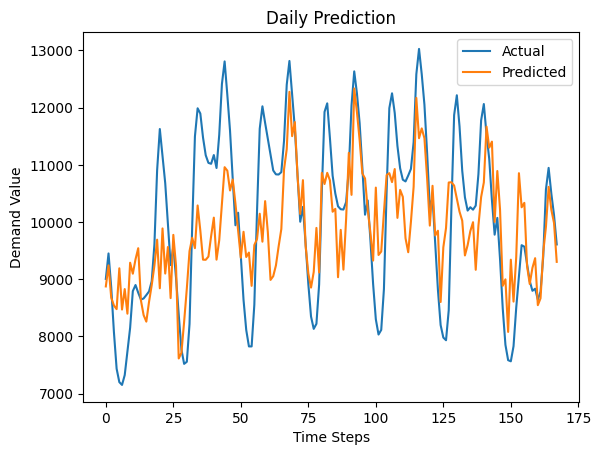

In [96]:
indice = 38  # Adjust the index as needed

# Set the title
plt.title("Daily Prediction")

# Plot the actual and predicted values
plt.plot(np.array(y_test[indice]), label="Actual")
plt.plot(np.array(y_pred[indice]), label="Predicted")

# Add labels to the x and y axes
plt.xlabel("Time Steps")
plt.ylabel("Demand Value")

# Add a legend to distinguish between actual and predicted lines
plt.legend()

# Show the plot
plt.show()

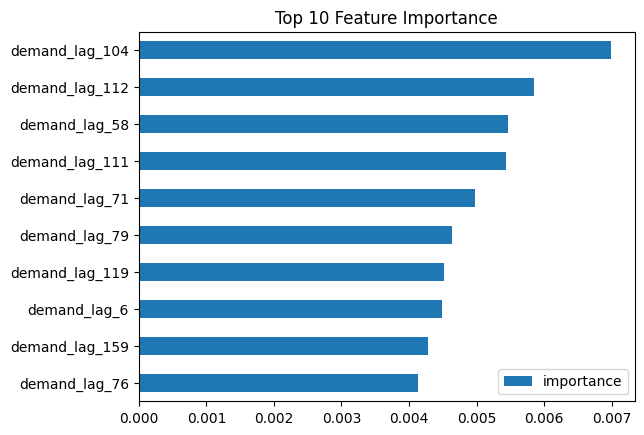

In [97]:
fi = pd.DataFrame(data=model.feature_importances_, index=df_X.columns, columns=['importance'])
fi = fi.sort_values(by='importance', ascending=False)

# Plot the top 10 features
top_n = 10
fi[:top_n].sort_values('importance').plot(kind='barh', title=f'Top {top_n} Feature Importance')
plt.show()